## **Import Library**

In [1]:
!pip install scikit-learn seaborn matplotlib hdbscan kmodes umap-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
import hdbscan
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from kmodes.kmodes import KModes
import umap.umap_ as umap
import re
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import random

_SEED = 42

os.environ['PYTHONHASHSEED'] = str(_SEED)

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

random.seed(_SEED)
np.random.seed(_SEED)

try:
    import torch
    torch.manual_seed(_SEED)
    torch.cuda.manual_seed_all(_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass
except Exception:
    # torch not installed or not available — skip
    pass

## **Load Dataset**

In [3]:
basket_url = "https://drive.google.com/uc?id=1vEfNytMeYVXsTH1Y_hMFhAnvLt3sOuZf"
category_url = "https://drive.google.com/uc?id=1HaaDRbwJ5J2vQtVJcuYBuibXz6VXSdQU"
frequency_url = "https://drive.google.com/uc?id=1GyNos3duh9aPSnD06OOY-hbhszvUStEq"
recency_url = "https://drive.google.com/uc?id=1io_YfzltnN4cyXzgiIRUV2QXOEuHXaCA"
spend_url = "https://drive.google.com/uc?id=1WKSHUO5Uais6mizB_QRzVH0OTACLsneb"
time_url = "https://drive.google.com/uc?id=1qb9AR5IJtVO6Csag5crIeAQvCErxOrXZ"

In [4]:
df_basket = pd.read_csv(basket_url)
df_category = pd.read_csv(category_url)
df_frequency = pd.read_csv(frequency_url)
df_recency = pd.read_csv(recency_url)
df_spend = pd.read_csv(spend_url)
df_time = pd.read_csv(time_url)

## **Clustering**

### **GLOBAL**

In [5]:
dfs = [df_basket, df_category, df_frequency, df_recency, df_spend, df_time]

df_global = dfs[0]
for df in dfs[1:]:
    df_global = df_global.merge(df, on='CustomerID', how='inner')

In [6]:
df_global.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0        260.636268         23.714286                     0.050713   
1         19.760904          2.000000                     0.000000   
2          0.000000         58.000000                     0.000000   
3          0.000000         16.000000                     0.000000   
4         59.702145          9.428571                     0.000000   

   share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                         0.185948                          0.049657   
1                         0.685714                          0.000000   
2                         0.084130                          0.036329   
3                         0.000000                          0.061224   
4                         0.128000                          0.030000   

   share_Dolly Girl (Lunch & Accesories)  ...  spend_velocity  spend_trend  \
0                               0.101426  ...      473.532857      -6.0725   
1                               0.000000  ...       30.066667     -17.9000   
2                               0.118547  ...      999.150000       0.0000   
3                               0.173469  ...      294.400000       0.0000   
4                               0.206000  ...      282.735000      -4.9020   

   morning_ratio  afternoon_ratio  evening_ratio  night_ratio  weekend_ratio  \
0       0.240964         0.759036       0.000000          0.0            0.0   
1       0.333333         0.000000       0.666667          0.0            0.0   
2       1.000000         0.000000       0.000000          0.0            0.0   
3       0.000000         1.000000       0.000000          0.0            0.0   
4       0.000000         1.000000       0.000000          0.0            0.0   

   peak_hour  monthly_txs_mean  monthly_txs_std  
0         14              1.00         0.000000  
1         19              1.00         0.000000  
2          9              1.00         0.000000  
3         16              1.00         0.000000  
4         14              1.75         0.957427  

[5 rows x 53 columns]

In [7]:
model = IsolationForest(contamination=0.05, random_state=0)
numeric_cols = df_global.select_dtypes(include=[np.number]).columns
df_global['Outlier_Scores'] = model.fit_predict(df_global[numeric_cols])
df_global['Is_Outlier'] = [1 if x == -1 else 0 for x in df_global['Outlier_Scores']]
df_global.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0        260.636268         23.714286                     0.050713   
1         19.760904          2.000000                     0.000000   
2          0.000000         58.000000                     0.000000   
3          0.000000         16.000000                     0.000000   
4         59.702145          9.428571                     0.000000   

   share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                         0.185948                          0.049657   
1                         0.685714                          0.000000   
2                         0.084130                          0.036329   
3                         0.000000                          0.061224   
4                         0.128000                          0.030000   

   share_Dolly Girl (Lunch & Accesories)  ...  morning_ratio  afternoon_ratio  \
0                               0.101426  ...       0.240964         0.759036   
1                               0.000000  ...       0.333333         0.000000   
2                               0.118547  ...       1.000000         0.000000   
3                               0.173469  ...       0.000000         1.000000   
4                               0.206000  ...       0.000000         1.000000   

   evening_ratio  night_ratio  weekend_ratio  peak_hour  monthly_txs_mean  \
0       0.000000          0.0            0.0         14              1.00   
1       0.666667          0.0            0.0         19              1.00   
2       0.000000          0.0            0.0          9              1.00   
3       0.000000          0.0            0.0         16              1.00   
4       0.000000          0.0            0.0         14              1.75   

   monthly_txs_std  Outlier_Scores  Is_Outlier  
0         0.000000               1           0  
1         0.000000               1           0  
2         0.000000               1           0  
3         0.000000               1           0  
4         0.957427               1           0  

[5 rows x 55 columns]

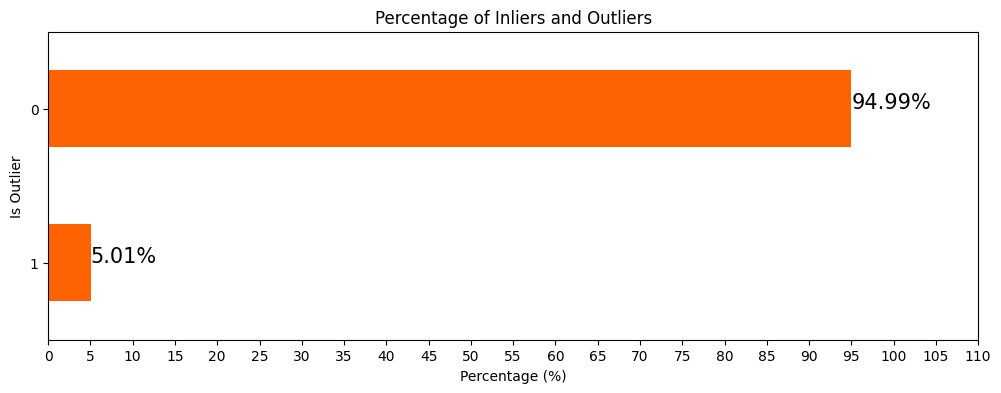

In [8]:
outlier_percentage = df_global['Is_Outlier'].value_counts(normalize=True) * 100
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [9]:
clean_ids = df_global.loc[df_global['Is_Outlier'] == 0, 'CustomerID']

In [10]:
df_global = df_global[df_global['CustomerID'].isin(clean_ids)]
df_global.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0        260.636268         23.714286                     0.050713   
1         19.760904          2.000000                     0.000000   
2          0.000000         58.000000                     0.000000   
3          0.000000         16.000000                     0.000000   
4         59.702145          9.428571                     0.000000   

   share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                         0.185948                          0.049657   
1                         0.685714                          0.000000   
2                         0.084130                          0.036329   
3                         0.000000                          0.061224   
4                         0.128000                          0.030000   

   share_Dolly Girl (Lunch & Accesories)  ...  morning_ratio  afternoon_ratio  \
0                               0.101426  ...       0.240964         0.759036   
1                               0.000000  ...       0.333333         0.000000   
2                               0.118547  ...       1.000000         0.000000   
3                               0.173469  ...       0.000000         1.000000   
4                               0.206000  ...       0.000000         1.000000   

   evening_ratio  night_ratio  weekend_ratio  peak_hour  monthly_txs_mean  \
0       0.000000          0.0            0.0         14              1.00   
1       0.666667          0.0            0.0         19              1.00   
2       0.000000          0.0            0.0          9              1.00   
3       0.000000          0.0            0.0         16              1.00   
4       0.000000          0.0            0.0         14              1.75   

   monthly_txs_std  Outlier_Scores  Is_Outlier  
0         0.000000               1           0  
1         0.000000               1           0  
2         0.000000               1           0  
3         0.000000               1           0  
4         0.957427               1           0  

[5 rows x 55 columns]

### **BASKET**

#### **Preprocessing**

In [11]:
df_basket_clean   = df_basket[df_basket['CustomerID'].isin(clean_ids)]
df_basket_clean.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  
0        260.636268         23.714286  
1         19.760904          2.000000  
2          0.000000         58.000000  
3          0.000000         16.000000  
4         59.702145          9.428571

In [12]:
klaster_basket = df_basket_clean.drop(['CustomerID', 'basket_std', 'basket_value_std'], axis = 1)

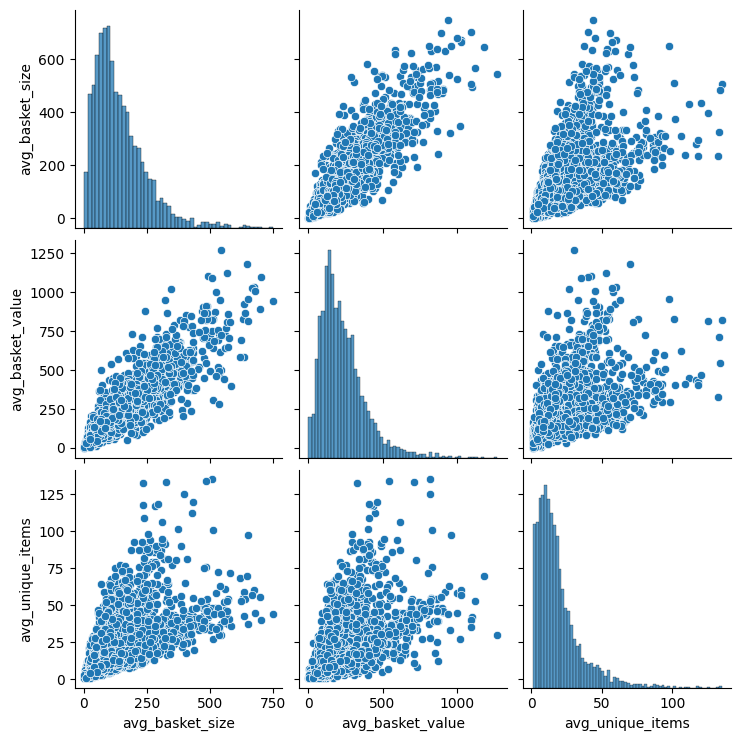

In [13]:
sns.pairplot(klaster_basket)

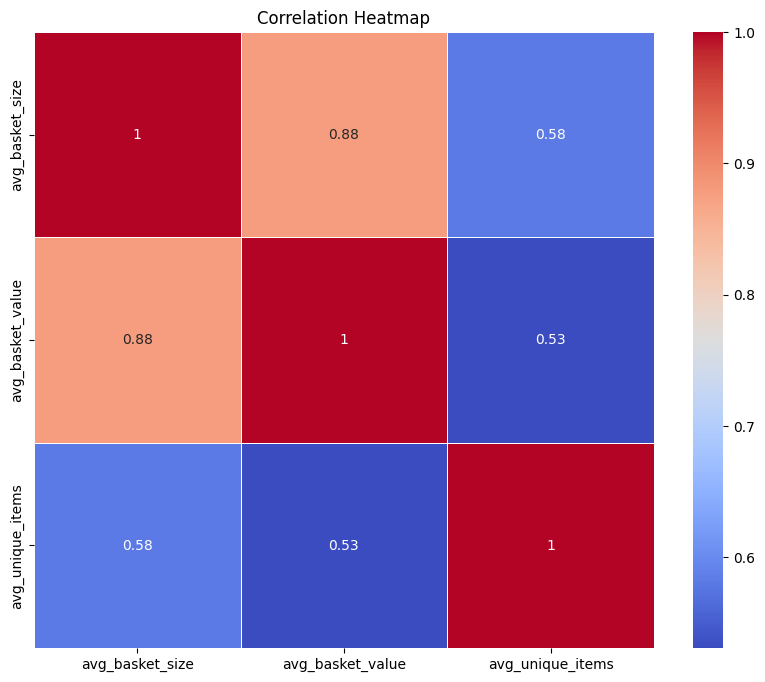

In [14]:
correlation_matrix = klaster_basket.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
X_log = np.log1p(klaster_basket)  # log(1 + x)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

In [16]:
features = df_basket_clean.columns.drop(['CustomerID', 'basket_std', 'basket_value_std'])
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

avg_basket_size  avg_basket_value  avg_unique_items
0         1.120801          1.262566          0.633646
1        -1.018587         -2.434823         -2.074648
2         1.929828          2.273748          1.751188
3         0.726621          0.619705          0.153101
4        -0.504031         -0.190333         -0.474490

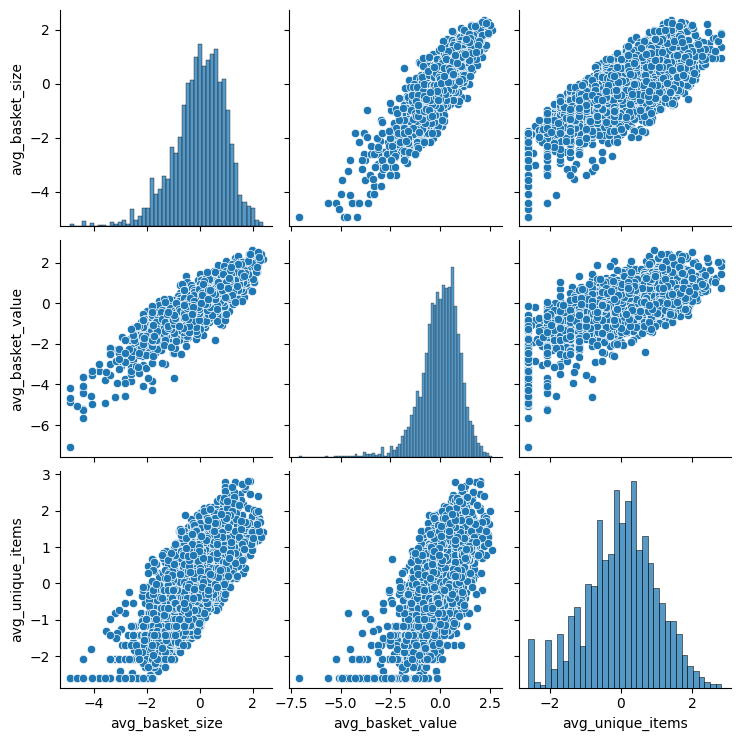

In [17]:
sns.pairplot(X_scaled)

#### **Modelling**

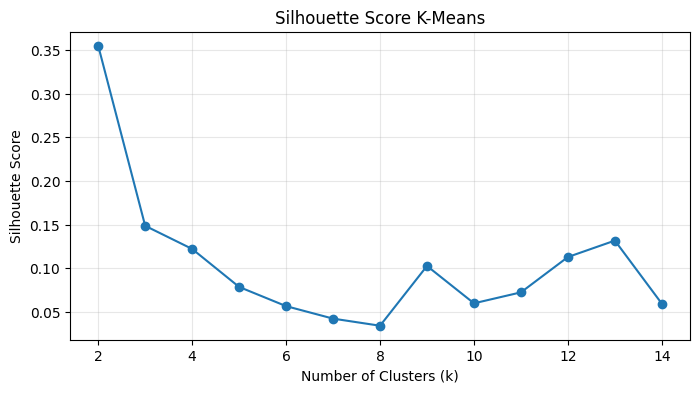

Best k berdasarkan silhouette: 2


In [18]:
X= X_scaled
K_range = range(2,15)
sil_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score K-Means")
plt.grid(alpha=0.3)
plt.show()

best_k_silhouette = K_range[sil_scores.index(max(sil_scores))]
print("Best k berdasarkan silhouette:", best_k_silhouette)

In [19]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
gmm_label = gmm.predict(X_scaled)

In [20]:
gmm_sscore = silhouette_score(X_scaled, gmm_label)
print("Silhouette Score:", gmm_sscore)

Silhouette Score: 0.3550564337887588


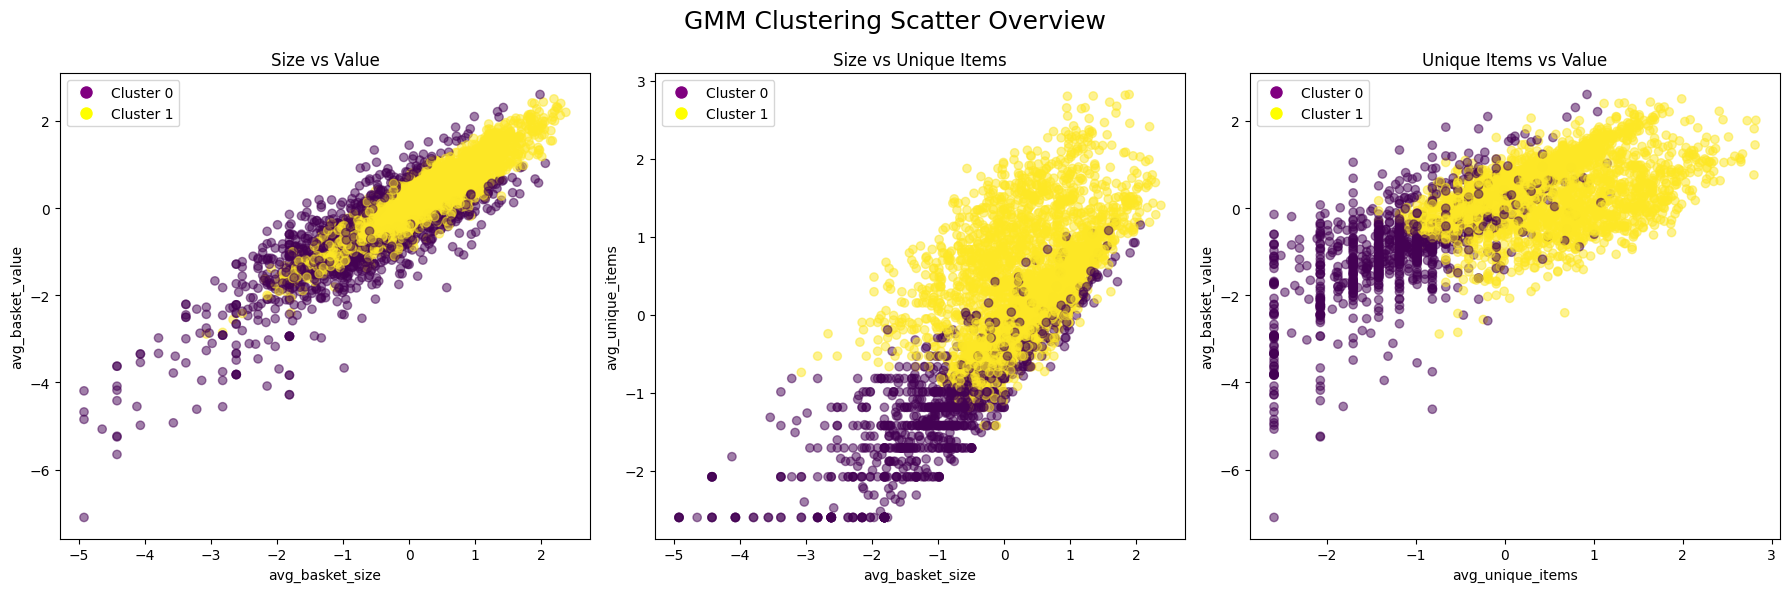

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("GMM Clustering Scatter Overview", fontsize=18)
handles = [plt.Line2D([], [], marker='o', color='w', label='Cluster 0',
                      markerfacecolor='purple', markersize=10),
           plt.Line2D([], [], marker='o', color='w', label='Cluster 1',
                      markerfacecolor='yellow', markersize=10)]
# Scatter 1: size vs value
ax[0].scatter(X_scaled['avg_basket_size'], X_scaled['avg_basket_value'], c=gmm_label, cmap='viridis', alpha = 0.5)
ax[0].set_xlabel('avg_basket_size')
ax[0].set_ylabel('avg_basket_value')
ax[0].set_title('Size vs Value')
ax[0].legend(handles=handles)

# Scatter 2: size vs unique_items
ax[1].scatter(X_scaled['avg_basket_size'], X_scaled['avg_unique_items'], c=gmm_label, cmap='viridis', alpha = 0.5)
ax[1].set_xlabel('avg_basket_size')
ax[1].set_ylabel('avg_unique_items')
ax[1].set_title('Size vs Unique Items')
ax[1].legend(handles=handles)

# Scatter 3: unique_items vs value
ax[2].scatter(X_scaled['avg_unique_items'], X_scaled['avg_basket_value'], c=gmm_label, cmap='viridis', alpha = 0.5)
ax[2].set_xlabel('avg_unique_items')
ax[2].set_ylabel('avg_basket_value')
ax[2].set_title('Unique Items vs Value')
ax[2].legend(handles=handles)

plt.tight_layout()
plt.show()

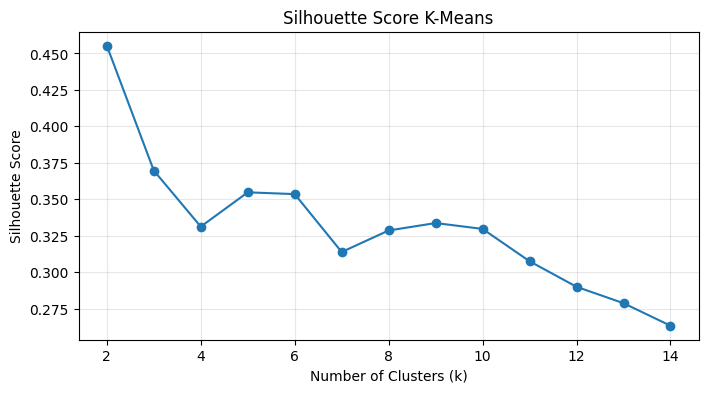

Best k berdasarkan silhouette: 2


In [22]:
X= X_scaled
K_range = range(2,15)
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score K-Means")
plt.grid(alpha=0.3)
plt.show()

best_k_silhouette = K_range[sil_scores.index(max(sil_scores))]
print("Best k berdasarkan silhouette:", best_k_silhouette)

In [23]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
kmeans_label = kmeans.predict(X_scaled)

In [24]:
kmeans_sscore = silhouette_score(X_scaled, kmeans_label)
print("Silhouette Score:", kmeans_sscore)

Silhouette Score: 0.4553001079749745


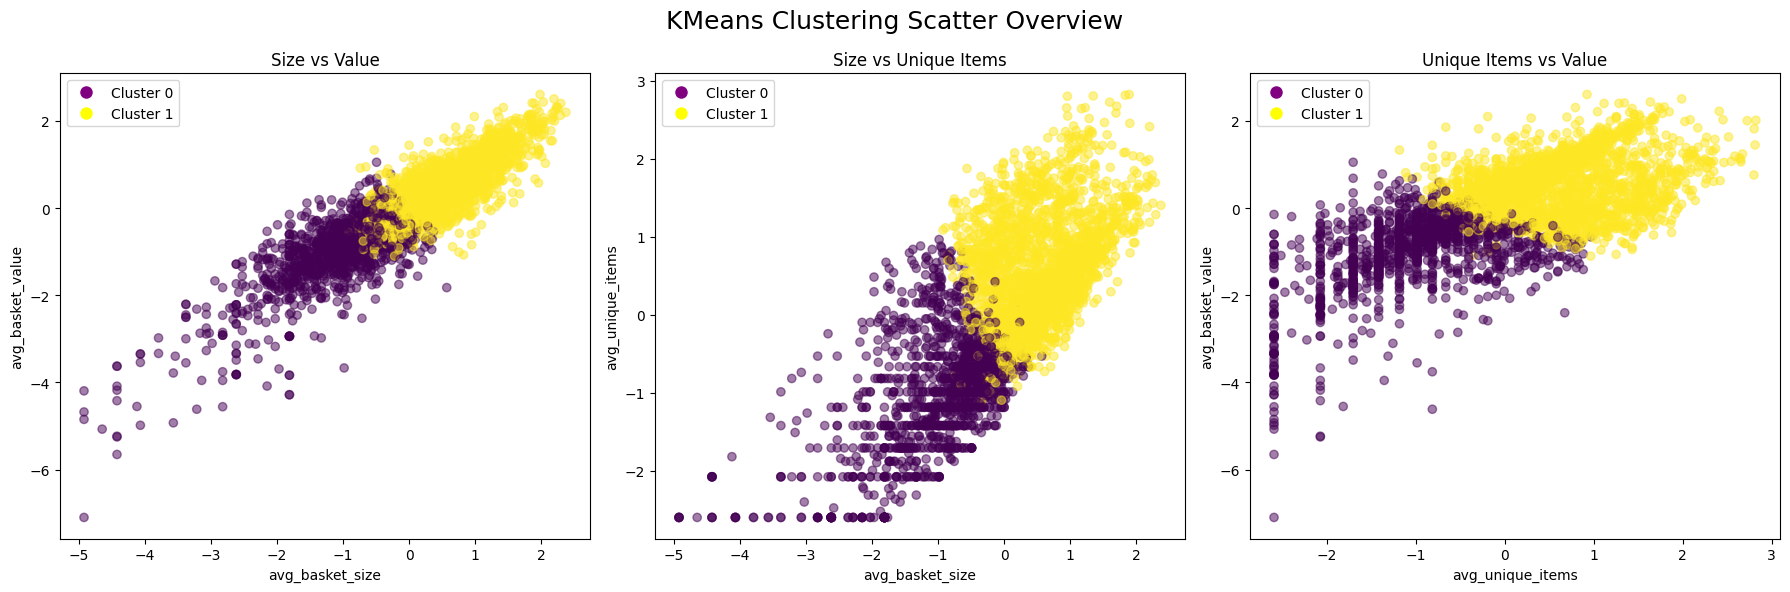

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("KMeans Clustering Scatter Overview", fontsize=18)
handles = [plt.Line2D([], [], marker='o', color='w', label='Cluster 0',
                      markerfacecolor='purple', markersize=10),
           plt.Line2D([], [], marker='o', color='w', label='Cluster 1',
                      markerfacecolor='yellow', markersize=10)]
# Scatter 1: size vs value
ax[0].scatter(X_scaled['avg_basket_size'], X_scaled['avg_basket_value'], c=kmeans_label, cmap='viridis', alpha = 0.5)
ax[0].set_xlabel('avg_basket_size')
ax[0].set_ylabel('avg_basket_value')
ax[0].set_title('Size vs Value')
ax[0].legend(handles=handles)

# Scatter 2: size vs unique_items
ax[1].scatter(X_scaled['avg_basket_size'], X_scaled['avg_unique_items'], c=kmeans_label, cmap='viridis', alpha = 0.5)
ax[1].set_xlabel('avg_basket_size')
ax[1].set_ylabel('avg_unique_items')
ax[1].set_title('Size vs Unique Items')
ax[1].legend(handles=handles)

# Scatter 3: unique_items vs value
ax[2].scatter(X_scaled['avg_unique_items'], X_scaled['avg_basket_value'], c=kmeans_label, cmap='viridis', alpha = 0.5)
ax[2].set_xlabel('avg_unique_items')
ax[2].set_ylabel('avg_basket_value')
ax[2].set_title('Unique Items vs Value')
ax[2].legend(handles=handles)

plt.tight_layout()
plt.show()

Model yang terpilih adalah **Kmeans clustering** dengan silhouette score tertinggi yaitu 45% dan visualisasi yang terlihat jelas perbedaan clusternya

#### **Apply on Global Data**

In [26]:
df_global = df_global.assign(Basket_cluster=kmeans_label)
df_global.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0        260.636268         23.714286                     0.050713   
1         19.760904          2.000000                     0.000000   
2          0.000000         58.000000                     0.000000   
3          0.000000         16.000000                     0.000000   
4         59.702145          9.428571                     0.000000   

   share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                         0.185948                          0.049657   
1                         0.685714                          0.000000   
2                         0.084130                          0.036329   
3                         0.000000                          0.061224   
4                         0.128000                          0.030000   

   share_Dolly Girl (Lunch & Accesories)  ...  afternoon_ratio  evening_ratio  \
0                               0.101426  ...         0.759036       0.000000   
1                               0.000000  ...         0.000000       0.666667   
2                               0.118547  ...         0.000000       0.000000   
3                               0.173469  ...         1.000000       0.000000   
4                               0.206000  ...         1.000000       0.000000   

   night_ratio  weekend_ratio  peak_hour  monthly_txs_mean  monthly_txs_std  \
0          0.0            0.0         14              1.00         0.000000   
1          0.0            0.0         19              1.00         0.000000   
2          0.0            0.0          9              1.00         0.000000   
3          0.0            0.0         16              1.00         0.000000   
4          0.0            0.0         14              1.75         0.957427   

   Outlier_Scores  Is_Outlier  Basket_cluster  
0               1           0               1  
1               1           0               0  
2               1           0               1  
3               1           0               1  
4               1           0               0  

[5 rows x 56 columns]

In [27]:
df_basket_clean = df_basket_clean.assign(Basket_cluster=kmeans_label)
df_basket_clean.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  Basket_cluster  
0        260.636268         23.714286               1  
1         19.760904          2.000000               0  
2          0.000000         58.000000               1  
3          0.000000         16.000000               1  
4         59.702145          9.428571               0

### **CATEGORY**

#### **Preprocessing**

In [28]:
df_category_clean = df_category[df_category['CustomerID'].isin(clean_ids)]
df_category_clean.head()

CustomerID  share_Bakelite Alarm Clocks  share_Cake Cases & Baking Items  \
0       12347                     0.050713                         0.185948   
1       12348                     0.000000                         0.685714   
2       12349                     0.000000                         0.084130   
3       12350                     0.000000                         0.000000   
4       12352                     0.000000                         0.128000   

   share_Christmas Paper Craft Kits  share_Dolly Girl (Lunch & Accesories)  \
0                          0.049657                               0.101426   
1                          0.000000                               0.000000   
2                          0.036329                               0.118547   
3                          0.061224                               0.173469   
4                          0.030000                               0.206000   

   share_Hanging Light Decor  share_Hot Water Bottle  \
0                   0.085578                0.019017   
1                   0.000000                0.000000   
2                   0.045889                0.000000   
3                   0.000000                0.061224   
4                   0.124000                0.000000   

   share_Kitchen Tins & Pantry Set  share_Lunch Bags  share_Metal Signs  \
0                         0.039620          0.046487           0.041204   
1                         0.142857          0.000000           0.000000   
2                         0.191205          0.000000           0.042065   
3                         0.122449          0.000000           0.183673   
4                         0.258000          0.012000           0.036000   

   share_Party Buntings  share_Pink/Charlotte Bags  \
0              0.022187                   0.072900   
1              0.000000                   0.000000   
2              0.015296                   0.028681   
3              0.122449                   0.153061   
4              0.028000                   0.144000   

   share_Regency Teacup & Saucer  share_Retrospot Red Collection  \
0                       0.080296                        0.040148   
1                       0.000000                        0.000000   
2                       0.022945                        0.267686   
3                       0.000000                        0.122449   
4                       0.000000                        0.006000   

   share_Vintage Jumbo Bags  share_Wicker Heart Decor  \
0                  0.050713                  0.114105   
1                  0.000000                  0.171429   
2                  0.000000                  0.147228   
3                  0.000000                  0.000000   
4                  0.000000                  0.028000   

                    top_category_1                         top_category_2  \
0  share_Cake Cases & Baking Items               share_Wicker Heart Decor   
1  share_Cake Cases & Baking Items               share_Wicker Heart Decor   
2   share_Retrospot Red Collection        share_Kitchen Tins & Pantry Set   
3                share_Metal Signs  share_Dolly Girl (Lunch & Accesories)   
4  share_Kitchen Tins & Pantry Set  share_Dolly Girl (Lunch & Accesories)   

   category_diversity  category_entropy  
0                  15          2.538803  
1                   3          0.839033  
2                  11          2.059768  
3                   8          2.015888  
4                  11          1.984906

In [29]:
share_cols = [c for c in df_category_clean.columns if c.startswith("share_")]
df_category_clean["top_share"] = df_category_clean[share_cols].max(axis=1)
features = df_category_clean[share_cols + ["category_entropy"]].copy()

/tmp/ipython-input-4292447969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category_clean["top_share"] = df_category_clean[share_cols].max(axis=1)


In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [31]:
scores = {}

for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores[k] = silhouette_score(X_scaled, labels)

scores

{2: np.float64(0.7224024447599727),
 3: np.float64(0.15653076764681542),
 4: np.float64(0.15231308694315882),
 5: np.float64(0.1273950291078568),
 6: np.float64(0.12725320896870532),
 7: np.float64(0.11727296209153426),
 8: np.float64(0.13139608035644793),
 9: np.float64(0.1276008233757681),
 10: np.float64(0.13907561759784065),
 11: np.float64(0.15377441513500492),
 12: np.float64(0.16867741187302224),
 13: np.float64(0.16647351543681882),
 14: np.float64(0.1123202045731402)}

In [32]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
df_category_clean["cluster"] = kmeans.fit_predict(X_scaled)

/tmp/ipython-input-1251445177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category_clean["cluster"] = kmeans.fit_predict(X_scaled)


In [33]:
cluster_profiles = df_category_clean.groupby("cluster").agg({
    **{col: "mean" for col in share_cols},
    "category_entropy": "mean"
}).reset_index()

In [34]:
cluster_profiles

cluster  share_Bakelite Alarm Clocks  share_Cake Cases & Baking Items  \
0        0                     0.004638                         0.068956   
1        1                     0.641248                         0.007419   

   share_Christmas Paper Craft Kits  share_Dolly Girl (Lunch & Accesories)  \
0                          0.091237                               0.132325   
1                          0.002809                               0.140480   

   share_Hanging Light Decor  share_Hot Water Bottle  \
0                   0.094312                0.030739   
1                   0.000000                0.000000   

   share_Kitchen Tins & Pantry Set  share_Lunch Bags  share_Metal Signs  \
0                         0.113111          0.034507           0.060924   
1                         0.021226          0.000000           0.044110   

   share_Party Buntings  share_Pink/Charlotte Bags  \
0              0.026178                   0.061944   
1              0.000000                   0.029855   

   share_Regency Teacup & Saucer  share_Retrospot Red Collection  \
0                       0.029026                        0.074028   
1                       0.021443                        0.039866   

   share_Vintage Jumbo Bags  share_Wicker Heart Decor  category_entropy  
0                  0.037187                  0.140887          1.747487  
1                  0.001404                  0.050140          0.853595

In [35]:
cluster_profiles["top_category"] = cluster_profiles[share_cols].idxmax(axis=1)
cluster_profiles["top_share"] = cluster_profiles[share_cols].max(axis=1)
# second strongest category:
cluster_profiles["second_category"] = cluster_profiles[share_cols].apply(
    lambda r: r.sort_values(ascending=False).index[1], axis=1
)
cluster_profiles["second_share"] = cluster_profiles[share_cols].apply(
    lambda r: r.sort_values(ascending=False).iloc[1], axis=1
)

In [36]:
def persona_label(row):
    s1, s2, entropy = row["top_share"], row["second_share"], row["category_entropy"]
    cat1 = row["top_category"].replace("share_", "")
    cat2 = row["second_category"].replace("share_", "")
    if s1 > 0.8:
        return f"{cat1} Loyalist"
    elif 0.4 < s1 <= 0.8 and entropy < 1.5:
        return f"{cat1} Focused Shopper"
    elif 0.30 < s1 <= 0.60 and entropy >= 1.5:
        return f"Balanced {cat1}-{cat2} Hybrid Shopper"
    elif s1 < 0.30 and entropy > 2.3:
        return "Variety Explorer"
    else:
        return "General Shopper"
cluster_profiles["persona"] = cluster_profiles.apply(persona_label, axis=1)

In [37]:
cluster_profiles

cluster  share_Bakelite Alarm Clocks  share_Cake Cases & Baking Items  \
0        0                     0.004638                         0.068956   
1        1                     0.641248                         0.007419   

   share_Christmas Paper Craft Kits  share_Dolly Girl (Lunch & Accesories)  \
0                          0.091237                               0.132325   
1                          0.002809                               0.140480   

   share_Hanging Light Decor  share_Hot Water Bottle  \
0                   0.094312                0.030739   
1                   0.000000                0.000000   

   share_Kitchen Tins & Pantry Set  share_Lunch Bags  share_Metal Signs  ...  \
0                         0.113111          0.034507           0.060924  ...   
1                         0.021226          0.000000           0.044110  ...   

   share_Regency Teacup & Saucer  share_Retrospot Red Collection  \
0                       0.029026                        0.074028   
1                       0.021443                        0.039866   

   share_Vintage Jumbo Bags  share_Wicker Heart Decor  category_entropy  \
0                  0.037187                  0.140887          1.747487   
1                  0.001404                  0.050140          0.853595   

                  top_category  top_share  \
0     share_Wicker Heart Decor   0.140887   
1  share_Bakelite Alarm Clocks   0.641248   

                         second_category  second_share  \
0  share_Dolly Girl (Lunch & Accesories)      0.132325   
1  share_Dolly Girl (Lunch & Accesories)      0.140480   

                                 persona  
0                        General Shopper  
1  Bakelite Alarm Clocks Focused Shopper  

[2 rows x 22 columns]

In [38]:
def get_persona(row):
    share = row["top_share"]
    entropy = row["category_entropy"]
    top_cat = row["top_category_1"].replace("share_", "")  # cleaner name

    if share > 0.7 and entropy < 1.0:
        return f"{top_cat} Loyalist"
    elif share > 0.45 and entropy < 1.5:
        return f"{top_cat} Dominant Shopper"
    elif share > 0.30 and entropy < 2.2:
        return f"{top_cat} Leaning Shopper"
    else:
        return "Variety Explorer"

In [39]:
df_category_clean["persona"] = df_category_clean.apply(get_persona, axis=1)

/tmp/ipython-input-4033498012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category_clean["persona"] = df_category_clean.apply(get_persona, axis=1)


In [40]:
df_global["Category persona"] = df_category_clean.apply(get_persona, axis=1)

In [41]:
df_category_clean.head()

CustomerID  share_Bakelite Alarm Clocks  share_Cake Cases & Baking Items  \
0       12347                     0.050713                         0.185948   
1       12348                     0.000000                         0.685714   
2       12349                     0.000000                         0.084130   
3       12350                     0.000000                         0.000000   
4       12352                     0.000000                         0.128000   

   share_Christmas Paper Craft Kits  share_Dolly Girl (Lunch & Accesories)  \
0                          0.049657                               0.101426   
1                          0.000000                               0.000000   
2                          0.036329                               0.118547   
3                          0.061224                               0.173469   
4                          0.030000                               0.206000   

   share_Hanging Light Decor  share_Hot Water Bottle  \
0                   0.085578                0.019017   
1                   0.000000                0.000000   
2                   0.045889                0.000000   
3                   0.000000                0.061224   
4                   0.124000                0.000000   

   share_Kitchen Tins & Pantry Set  share_Lunch Bags  share_Metal Signs  ...  \
0                         0.039620          0.046487           0.041204  ...   
1                         0.142857          0.000000           0.000000  ...   
2                         0.191205          0.000000           0.042065  ...   
3                         0.122449          0.000000           0.183673  ...   
4                         0.258000          0.012000           0.036000  ...   

   share_Retrospot Red Collection  share_Vintage Jumbo Bags  \
0                        0.040148                  0.050713   
1                        0.000000                  0.000000   
2                        0.267686                  0.000000   
3                        0.122449                  0.000000   
4                        0.006000                  0.000000   

   share_Wicker Heart Decor                   top_category_1  \
0                  0.114105  share_Cake Cases & Baking Items   
1                  0.171429  share_Cake Cases & Baking Items   
2                  0.147228   share_Retrospot Red Collection   
3                  0.000000                share_Metal Signs   
4                  0.028000  share_Kitchen Tins & Pantry Set   

                          top_category_2  category_diversity category_entropy  \
0               share_Wicker Heart Decor                  15         2.538803   
1               share_Wicker Heart Decor                   3         0.839033   
2        share_Kitchen Tins & Pantry Set                  11         2.059768   
3  share_Dolly Girl (Lunch & Accesories)                   8         2.015888   
4  share_Dolly Girl (Lunch & Accesories)                  11         1.984906   

  top_share  cluster                                     persona  
0  0.185948        0                            Variety Explorer  
1  0.685714        0  Cake Cases & Baking Items Dominant Shopper  
2  0.267686        0                            Variety Explorer  
3  0.183673        0                            Variety Explorer  
4  0.258000        0                            Variety Explorer  

[5 rows x 23 columns]

### **FREQUENCY**

In [42]:
df_frequency_clean = df_frequency[df_frequency['CustomerID'].isin(clean_ids)]
df_frequency_clean.head()

CustomerID  purchase_frequency  unique_visit_days  purchase_per_month  \
0       12347                   7                  7                1.00   
1       12348                   3                  3                1.00   
2       12349                   1                  1                1.00   
3       12350                   1                  1                1.00   
4       12352                   7                  7                1.75   

   order_interval_mean  order_interval_std  
0             2.193939           11.778907  
1            21.800000           31.799371  
2             0.000000            0.000000  
3             0.000000            0.000000  
4             3.969231           22.870539

In [43]:
klaster_frequency = df_frequency_clean.drop('CustomerID', axis = 1)

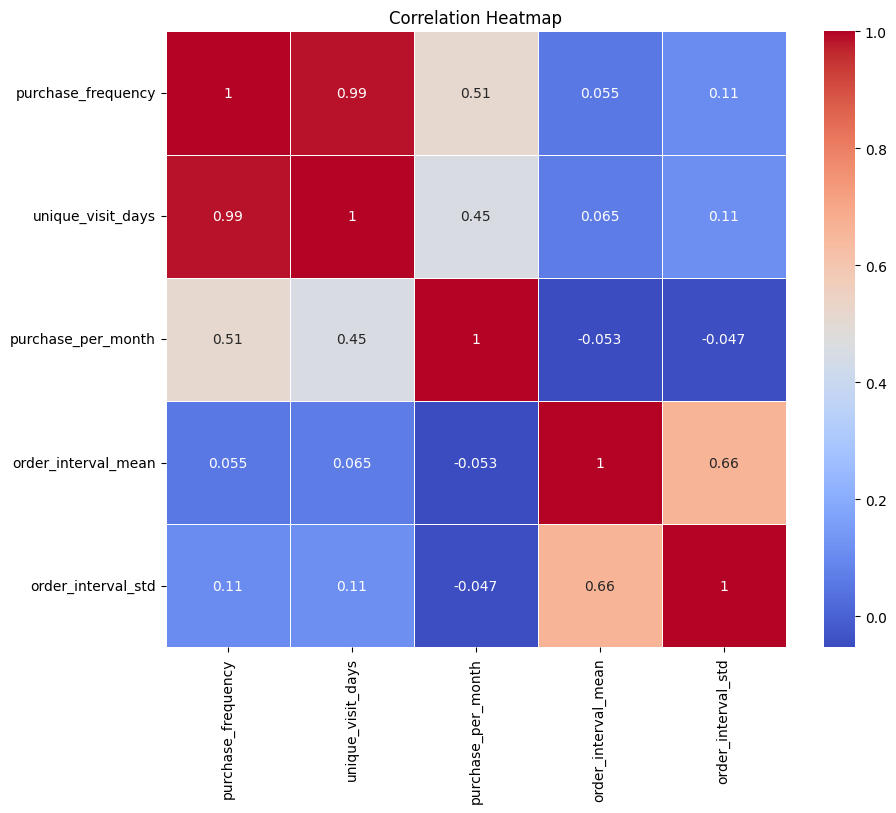

In [44]:
# correlation analysis
correlation_matrix = klaster_frequency.corr()
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

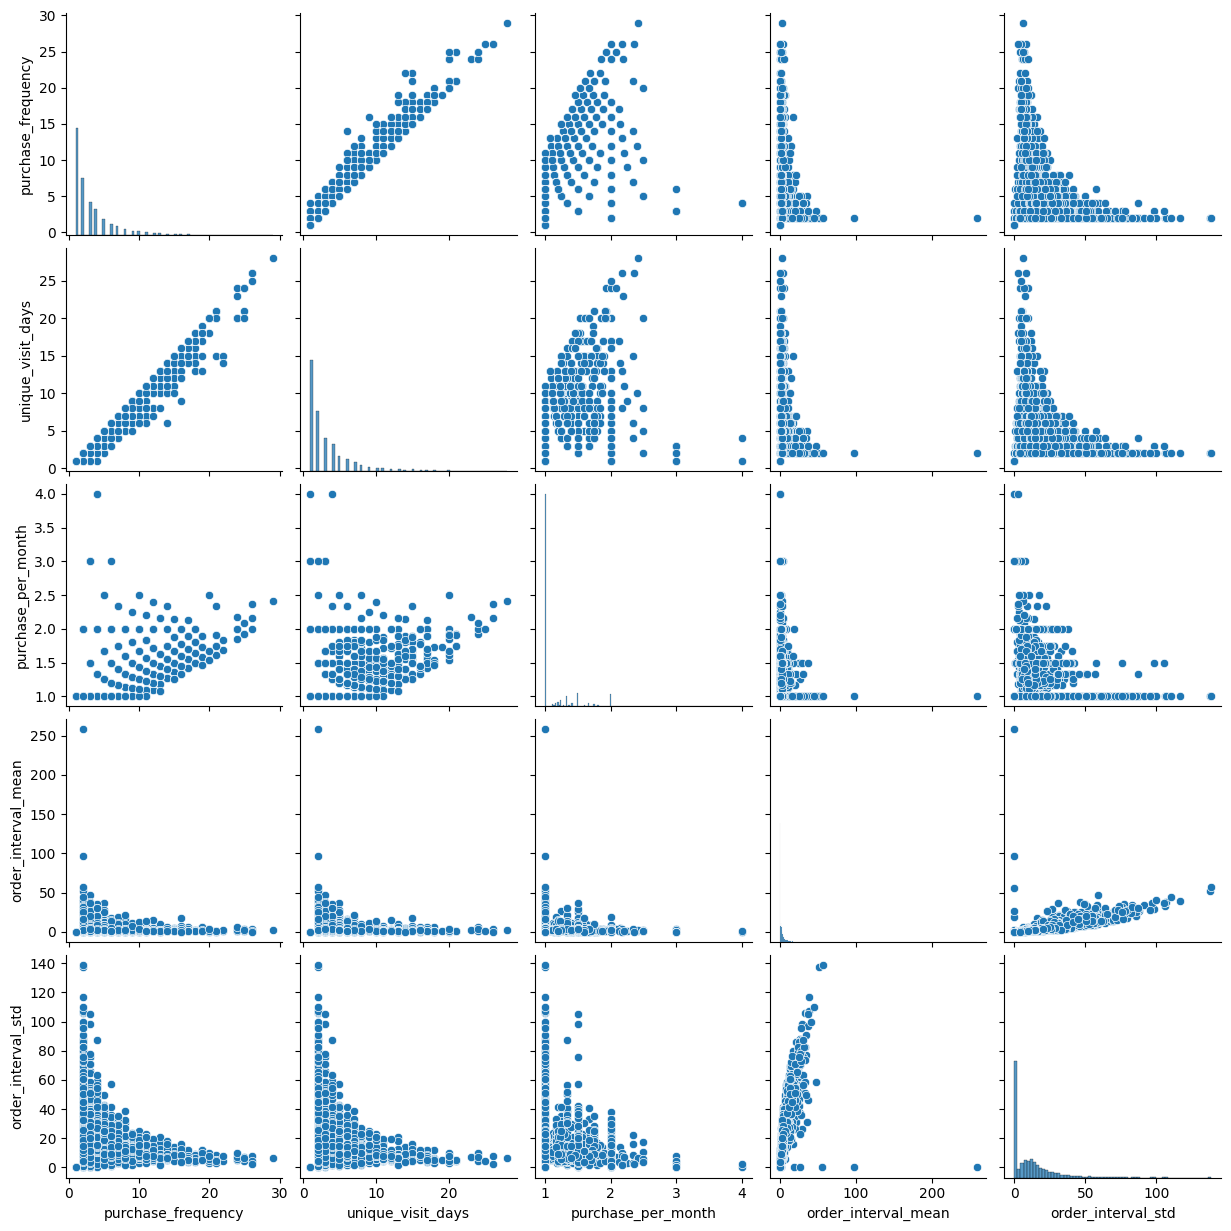

In [45]:
sns.pairplot(klaster_frequency)

In [46]:
klaster_frequency = klaster_frequency['purchase_frequency'].to_frame()

array([[<Axes: title={'center': 'purchase_frequency'}>]], dtype=object)

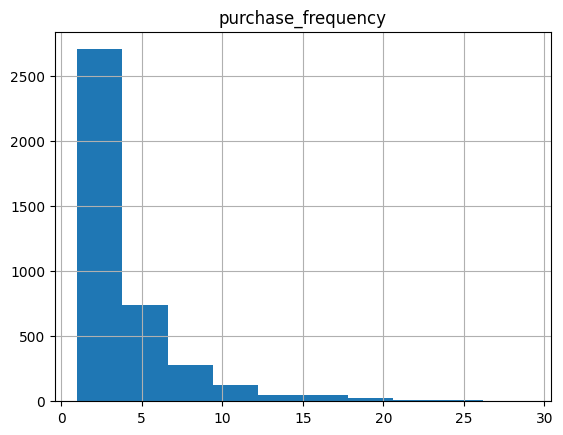

In [47]:
klaster_frequency.hist()

In [48]:
def segment_frequency(freq):
    if freq <= 2:
        return "Low"
    elif freq <= 5:
        return "Medium"
    elif freq <= 10:
        return "High"
    else:
        return "VIP"

klaster_frequency["frequency_segment"] = klaster_frequency["purchase_frequency"].apply(segment_frequency)
klaster_frequency["frequency_segment"].value_counts()

frequency_segment
Low       2250
Medium    1036
High       485
VIP        211
Name: count, dtype: int64

<Axes: title={'center': 'Customer Frequency Segmentation'}, xlabel='frequency_segment'>

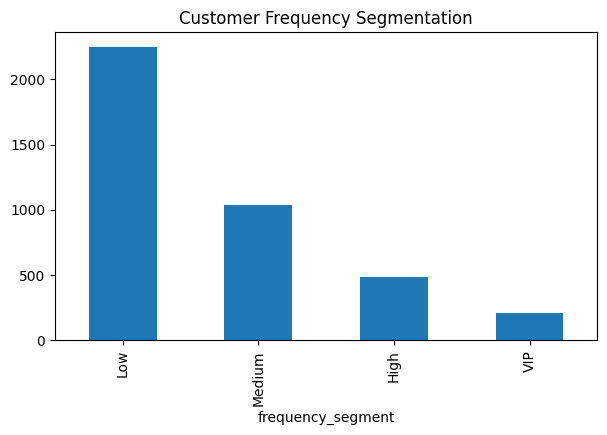

In [49]:
klaster_frequency["frequency_segment"].value_counts().plot(
    kind="bar",
    figsize=(7,4),
    title="Customer Frequency Segmentation"
)

In [50]:
# mapping frequency segment
mapping = {'High':2,'Medium':1,'Low':0,'VIP':3}
klaster_frequency['frequency_segment'] = klaster_frequency['frequency_segment'].map(mapping)

In [51]:
# assign df_global
df_global = df_global.assign(frequency_segment = klaster_frequency['frequency_segment'])
df_global

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0          12347       270.428571  131.817876        473.532857   
1          12348        46.666667   42.770706         30.066667   
2          12349       523.000000    0.000000        999.150000   
3          12350       196.000000    0.000000        294.400000   
4          12352        71.428571   32.974016        161.562857   
...          ...              ...         ...               ...   
4187       18280        40.000000    0.000000        137.000000   
4188       18281        52.000000    0.000000         46.920000   
4189       18282        25.500000    0.707107         56.565000   
4190       18283        84.562500   59.299206        125.164375   
4191       18287       259.333333  225.710729        320.253333   

      basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0           260.636268         23.714286                     0.050713   
1            19.760904          2.000000                     0.000000   
2             0.000000         58.000000                     0.000000   
3             0.000000         16.000000                     0.000000   
4            59.702145          9.428571                     0.000000   
...                ...               ...                          ...   
4187          0.000000          8.000000                     0.200000   
4188          0.000000          5.000000                     0.000000   
4189          5.975052          4.000000                     0.000000   
4190         77.591865         42.812500                     0.000000   
4191        273.780129         16.666667                     0.000000   

      share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                            0.185948                          0.049657   
1                            0.685714                          0.000000   
2                            0.084130                          0.036329   
3                            0.000000                          0.061224   
4                            0.128000                          0.030000   
...                               ...                               ...   
4187                         0.000000                          0.200000   
4188                         0.000000                          0.000000   
4189                         0.372549                          0.235294   
4190                         0.130081                          0.079084   
4191                         0.015424                          0.038560   

      share_Dolly Girl (Lunch & Accesories)  ...  night_ratio  weekend_ratio  \
0                                  0.101426  ...          0.0       0.000000   
1                                  0.000000  ...          0.0       0.000000   
2                                  0.118547  ...          0.0       0.000000   
3                                  0.173469  ...          0.0       0.000000   
4                                  0.206000  ...          0.0       0.000000   
...                                     ...  ...          ...            ...   
4187                               0.000000  ...          0.0       0.000000   
4188                               0.692308  ...          0.0       1.000000   
4189                               0.000000  ...          0.0       0.000000   
4190                               0.143385  ...          0.0       0.061367   
4191                               0.287918  ...          0.0       0.460000   

      peak_hour  monthly_txs_mean  monthly_txs_std  Outlier_Scores  \
0            14              1.00         0.000000               1   
1            19              1.00         0.000000               1   
2             9              1.00         0.000000               1   
3            16              1.00         0.000000               1   
4            14              1.75         0.957427               1   
...         ...               ...         

In [52]:
df_frequency_clean = df_frequency_clean.assign(frequency_segment = klaster_frequency['frequency_segment'])
df_frequency_clean

CustomerID  purchase_frequency  unique_visit_days  purchase_per_month  \
0          12347                   7                  7                1.00   
1          12348                   3                  3                1.00   
2          12349                   1                  1                1.00   
3          12350                   1                  1                1.00   
4          12352                   7                  7                1.75   
...          ...                 ...                ...                 ...   
4187       18280                   1                  1                1.00   
4188       18281                   1                  1                1.00   
4189       18282                   2                  2                1.00   
4190       18283                  16                 14                1.60   
4191       18287                   3                  3                1.50   

      order_interval_mean  order_interval_std  frequency_segment  
0                2.193939           11.778907                  2  
1               21.800000           31.799371                  1  
2                0.000000            0.000000                  0  
3                0.000000            0.000000                  0  
4                3.969231           22.870539                  2  
...                   ...                 ...                ...  
4187             0.000000            0.000000                  0  
4188             0.000000            0.000000                  0  
4189            16.857143           44.599808                  0  
4190             0.456704            4.063079                  3  
4191             3.204082           20.354135                  1  

[3982 rows x 7 columns]

### **RECENCY**

In [53]:
df_recency_clean   = df_recency[df_recency['CustomerID'].isin(clean_ids)]
df_recency_clean.head()

CustomerID        last_purchase  days_since_last_purchase  \
0       12347  2011-12-07 15:52:00                         1   
1       12348  2011-04-05 10:47:00                       248   
2       12349  2011-11-21 09:51:00                        18   
3       12350  2011-02-02 16:01:00                       309   
4       12352  2011-11-03 14:37:00                        35   

        first_purchase  time_since_first_purchase  avg_recency  recency_rank  \
0  2010-12-07 14:57:00                        366     2.193939             2   
1  2010-12-16 19:09:00                        357    21.800000           241   
2  2011-11-21 09:51:00                         18     0.000000            19   
3  2011-02-02 16:01:00                        309     0.000000           296   
4  2011-02-16 12:33:00                        296     3.969231            36   

   recency_zscore  
0       -0.905517  
1        1.567028  
2       -0.735342  
3        2.177657  
4       -0.565167

<Axes: >

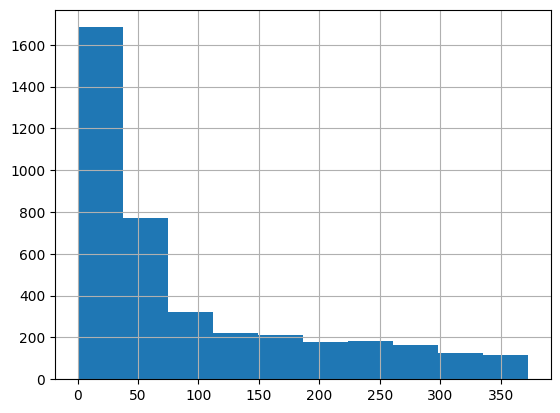

In [54]:
X = df_recency_clean['days_since_last_purchase']
X.hist()

In [55]:
q1, q2, q3 = (
    df_recency_clean['days_since_last_purchase'].quantile(0.25),
    df_recency_clean['days_since_last_purchase'].quantile(0.50),
    df_recency_clean['days_since_last_purchase'].quantile(0.75)
)

def recency_segment(x):
    if x <= q1:
        return "Active"
    elif x <= q2:
        return "Warm"
    elif x <= q3:
        return "Cool"
    elif x <= 180:
        return "At Risk"
    else:
        return "Lost"

df_recency_clean['recency_segment'] = df_recency_clean['days_since_last_purchase'].apply(recency_segment)

/tmp/ipython-input-1029177839.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency_clean['recency_segment'] = df_recency_clean['days_since_last_purchase'].apply(recency_segment)


<Axes: title={'center': 'Customer Recency Segmentation'}, xlabel='recency_segment'>

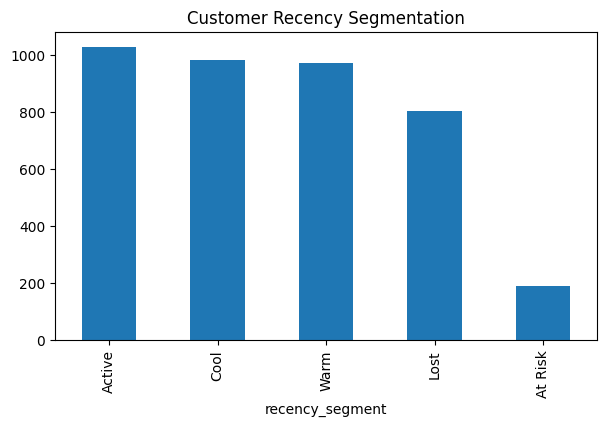

In [56]:
df_recency_clean['recency_segment'].value_counts().plot(
    kind="bar",
    figsize=(7,4),
    title="Customer Recency Segmentation"
)

In [57]:
# mapping
mapping = {'Active':0,'Warm':2,'Cool':1,'At Risk':3,'Lost':4}
df_recency_clean['recency_segment'] = df_recency_clean['recency_segment'].map(mapping)

/tmp/ipython-input-1774934729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency_clean['recency_segment'] = df_recency_clean['recency_segment'].map(mapping)


In [58]:
df_global = df_global.assign(recency_segment = df_recency_clean['recency_segment'])
df_global

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0          12347       270.428571  131.817876        473.532857   
1          12348        46.666667   42.770706         30.066667   
2          12349       523.000000    0.000000        999.150000   
3          12350       196.000000    0.000000        294.400000   
4          12352        71.428571   32.974016        161.562857   
...          ...              ...         ...               ...   
4187       18280        40.000000    0.000000        137.000000   
4188       18281        52.000000    0.000000         46.920000   
4189       18282        25.500000    0.707107         56.565000   
4190       18283        84.562500   59.299206        125.164375   
4191       18287       259.333333  225.710729        320.253333   

      basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0           260.636268         23.714286                     0.050713   
1            19.760904          2.000000                     0.000000   
2             0.000000         58.000000                     0.000000   
3             0.000000         16.000000                     0.000000   
4            59.702145          9.428571                     0.000000   
...                ...               ...                          ...   
4187          0.000000          8.000000                     0.200000   
4188          0.000000          5.000000                     0.000000   
4189          5.975052          4.000000                     0.000000   
4190         77.591865         42.812500                     0.000000   
4191        273.780129         16.666667                     0.000000   

      share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                            0.185948                          0.049657   
1                            0.685714                          0.000000   
2                            0.084130                          0.036329   
3                            0.000000                          0.061224   
4                            0.128000                          0.030000   
...                               ...                               ...   
4187                         0.000000                          0.200000   
4188                         0.000000                          0.000000   
4189                         0.372549                          0.235294   
4190                         0.130081                          0.079084   
4191                         0.015424                          0.038560   

      share_Dolly Girl (Lunch & Accesories)  ...  weekend_ratio  peak_hour  \
0                                  0.101426  ...       0.000000         14   
1                                  0.000000  ...       0.000000         19   
2                                  0.118547  ...       0.000000          9   
3                                  0.173469  ...       0.000000         16   
4                                  0.206000  ...       0.000000         14   
...                                     ...  ...            ...        ...   
4187                               0.000000  ...       0.000000          9   
4188                               0.692308  ...       1.000000         10   
4189                               0.000000  ...       0.000000         11   
4190                               0.143385  ...       0.061367         14   
4191                               0.287918  ...       0.460000         10   

      monthly_txs_mean  monthly_txs_std  Outlier_Scores  Is_Outlier  \
0                 1.00         0.000000               1           0   
1                 1.00         0.000000               1           0   
2                 1.00         0.000000               1           0   
3                 1.00         0.000000               1           0   
4                 1.75         0.957427               1           0   
...                ...              ...             ...     

In [59]:
df_recency_clean = df_recency_clean.assign(recency_segment = df_recency_clean['recency_segment'])

### **SPEND**

#### **Preprocessing**

In [60]:
df_spend_clean = df_spend[df_spend['CustomerID'].isin(clean_ids)]
df_spend_clean.head()

CustomerID  total_spend  total_transactions  total_items  avg_order_value  \
0       12347      3314.73                   7         1893       473.532857   
1       12348        90.20                   3          140        30.066667   
2       12349       999.15                   1          523       999.150000   
3       12350       294.40                   1          196       294.400000   
4       12352      1130.94                   7          500       161.562857   

   max_order_value  std_order_value  spend_velocity  spend_trend  
0           982.40       260.636268      473.532857      -6.0725  
1            52.80        19.760904       30.066667     -17.9000  
2           999.15         0.000000      999.150000       0.0000  
3           294.40         0.000000      294.400000       0.0000  
4           228.40        59.702145      282.735000      -4.9020

In [61]:
klaster_spend = df_spend_clean.drop('CustomerID', axis = 1)

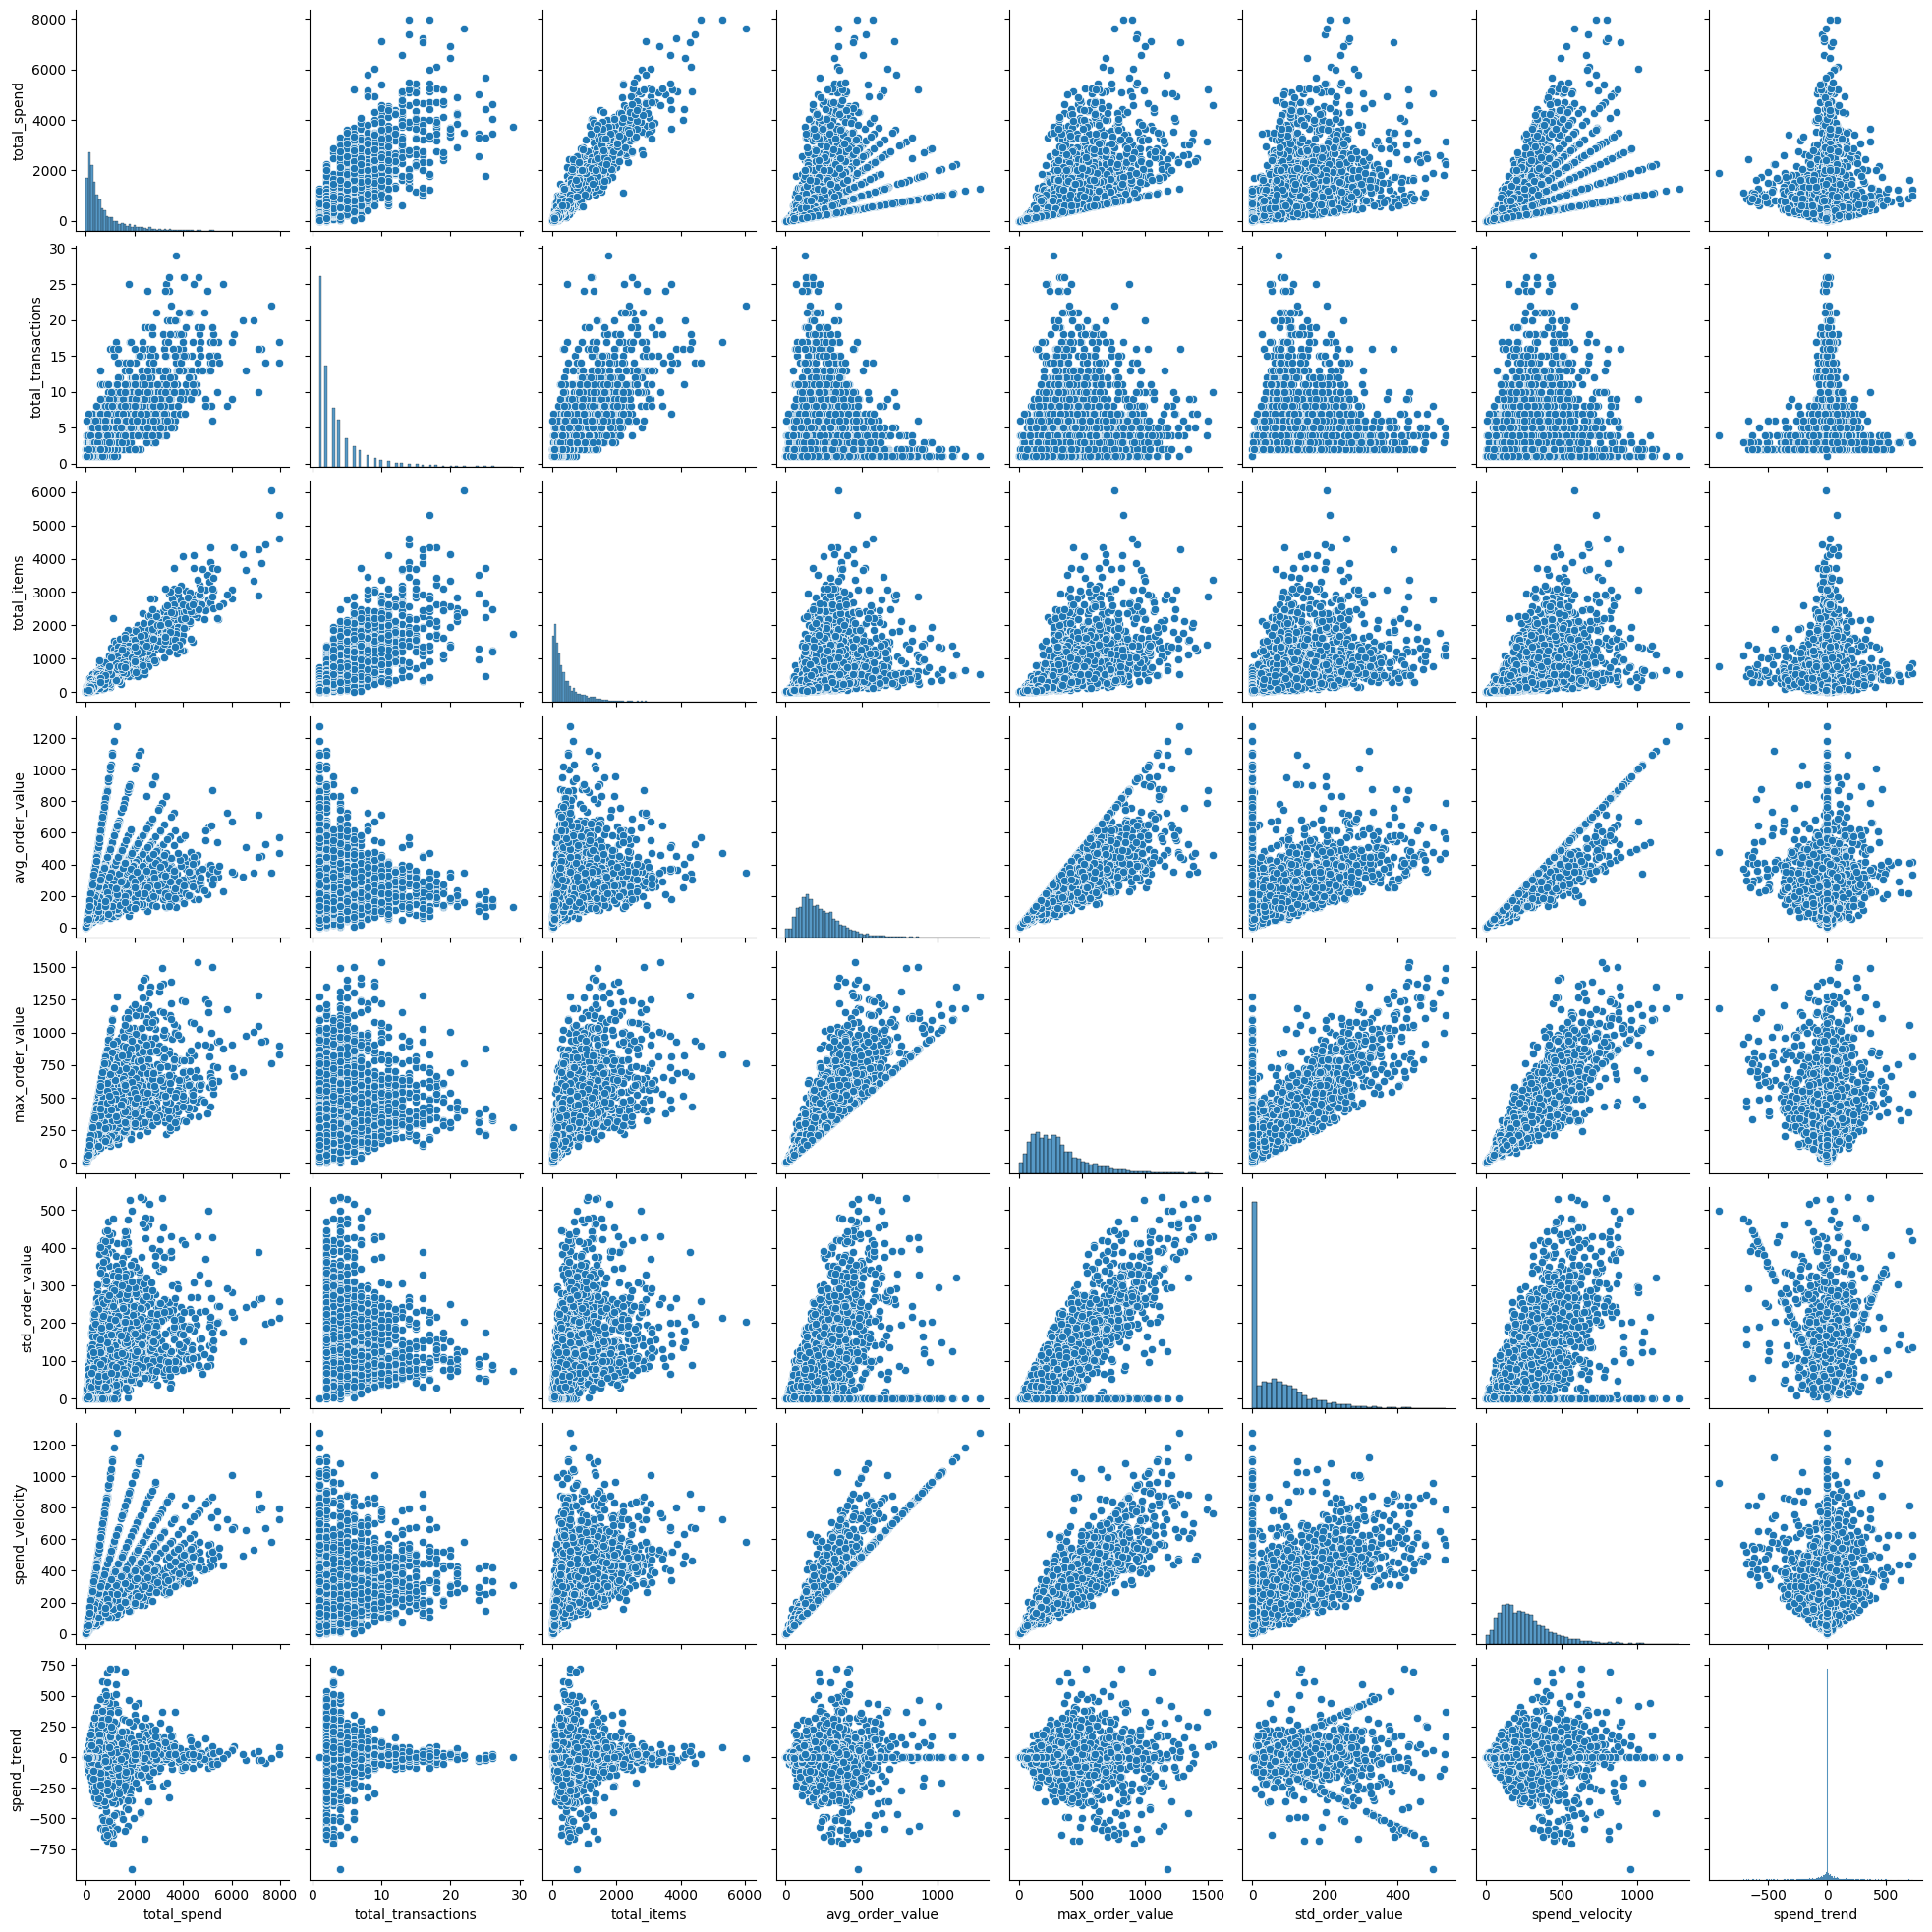

In [62]:
sns.pairplot(klaster_spend)

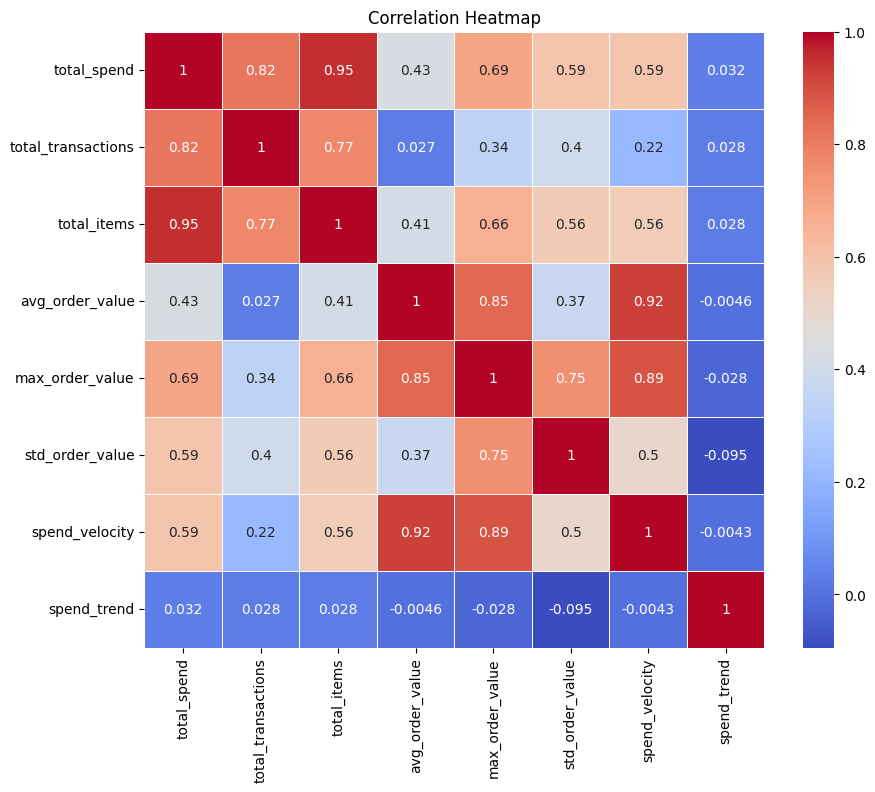

In [63]:
# heatmap korelasi
correlation_matrix = klaster_spend.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [64]:
klaster_spend = klaster_spend[['total_spend', 'total_transactions', 'avg_order_value']]

In [65]:
# standardisasi
scaler = RobustScaler()
X_scaled = scaler.fit_transform(klaster_spend)
X_scaled = pd.DataFrame(X_scaled, columns=['total_spend', 'total_transactions', 'avg_order_value'])
X_scaled.head()

total_spend  total_transactions  avg_order_value
0     3.472336            1.666667         1.550344
1    -0.421894            0.333333        -0.967437
2     0.675835           -0.333333         4.534537
3    -0.175284           -0.333333         0.533316
4     0.834996            1.666667        -0.220867

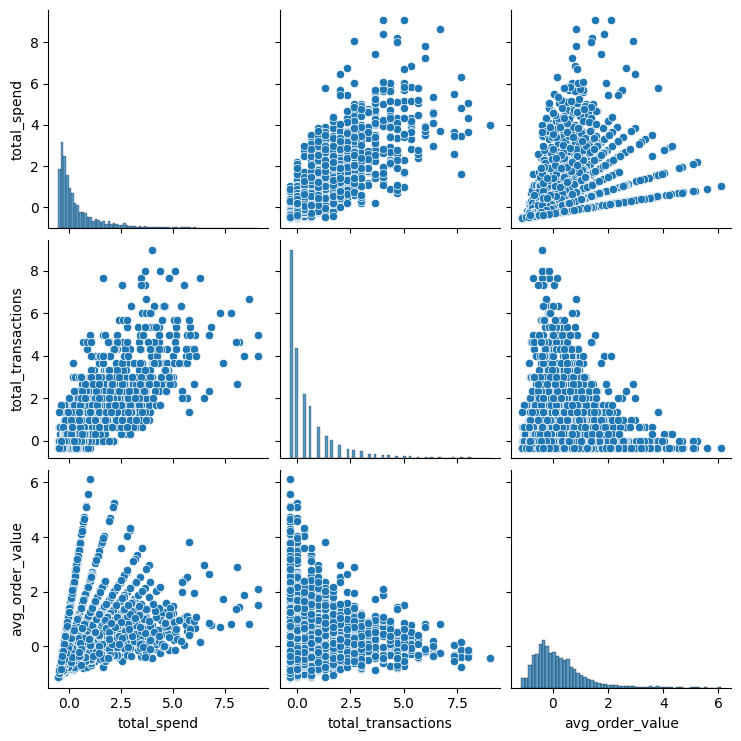

In [66]:
sns.pairplot(X_scaled)

#### **Modelling**

In [67]:
clusterer = hdbscan.HDBSCAN(
    metric='euclidean',
    min_cluster_size=50,
    cluster_selection_method='eom'
)

hdbscan_labels = clusterer.fit_predict(X_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [68]:
np.unique(hdbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [69]:
clusterer.cluster_persistence_

array([0.02223485, 0.07746854, 0.0870073 , 0.19452721, 0.02856145,
       0.26051758])

In [70]:
mask = hdbscan_labels != -1
sil = silhouette_score(X_scaled[mask], hdbscan_labels[mask])
sil

np.float64(0.15550402912511382)

In [71]:
labels = hdbscan_labels
persist = clusterer.cluster_persistence_

# Ambil centroid tiap cluster
centroids = []
for c in np.unique(labels):
    if c == -1:  # skip noise
        continue
    centroids.append(X_scaled[labels == c].mean(axis=0))

centroids = np.vstack(centroids)

# Threshold persistence
threshold = 0.5
low_clusters = [i for i, p in enumerate(persist) if p < threshold]

for c in low_clusters:
    # cari jarak centroid cluster ini ke lainnya
    dists = pairwise_distances([centroids[c]], centroids)[0]
    dists[c] = np.inf  # jangan ke dirinya sendiri
    target = np.argmin(dists)

    # gabungkan cluster
    labels[labels == c] = target

In [72]:
# Setelah proses merge, labels sudah ter-update.
merged_labels = labels.copy()

# --- Hitung ulang centroid tiap cluster setelah merge ---
merged_centroids = []
merged_cluster_ids = np.unique(merged_labels)

for cid in merged_cluster_ids:
    if cid == -1:  # skip noise
        continue
    merged_centroids.append(X_scaled[merged_labels == cid].mean(axis=0))

merged_centroids = np.vstack(merged_centroids)

# --- Hitung jumlah anggota tiap cluster ---
cluster_sizes = {cid: (merged_labels == cid).sum() for cid in merged_cluster_ids}

print("Cluster baru:", merged_cluster_ids)
print("Ukuran tiap cluster:", cluster_sizes)

Cluster baru: [-1  1  2  3]
Ukuran tiap cluster: {np.int64(-1): np.int64(1198), np.int64(1): np.int64(754), np.int64(2): np.int64(716), np.int64(3): np.int64(1314)}


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


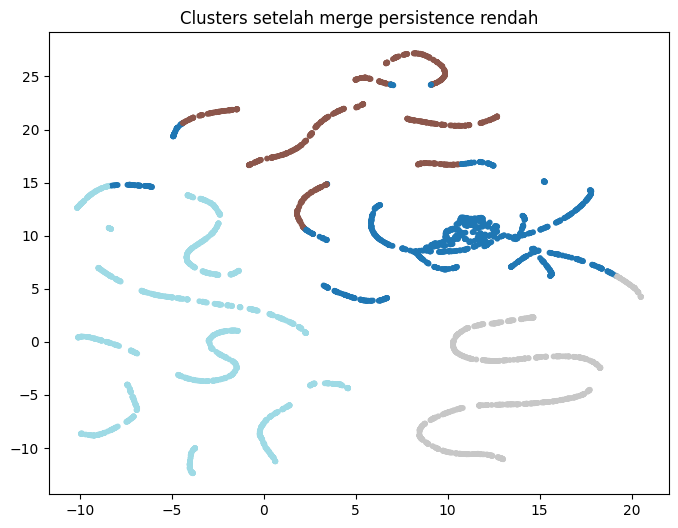

In [73]:
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    embedding[:,0], embedding[:,1],
    c=merged_labels, s=10, cmap='tab20'
)
plt.title("Clusters setelah merge persistence rendah")
plt.show()

In [74]:
mask = merged_labels != -1
sil = silhouette_score(X_scaled[mask], merged_labels[mask])
sil

np.float64(0.19817520388156476)

#### **Assign to Global Data**

In [75]:
df_global = df_global.assign(Spend_cluster = merged_labels)
df_global.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0        260.636268         23.714286                     0.050713   
1         19.760904          2.000000                     0.000000   
2          0.000000         58.000000                     0.000000   
3          0.000000         16.000000                     0.000000   
4         59.702145          9.428571                     0.000000   

   share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                         0.185948                          0.049657   
1                         0.685714                          0.000000   
2                         0.084130                          0.036329   
3                         0.000000                          0.061224   
4                         0.128000                          0.030000   

   share_Dolly Girl (Lunch & Accesories)  ...  peak_hour  monthly_txs_mean  \
0                               0.101426  ...         14              1.00   
1                               0.000000  ...         19              1.00   
2                               0.118547  ...          9              1.00   
3                               0.173469  ...         16              1.00   
4                               0.206000  ...         14              1.75   

   monthly_txs_std  Outlier_Scores  Is_Outlier  Basket_cluster  \
0         0.000000               1           0               1   
1         0.000000               1           0               0   
2         0.000000               1           0               1   
3         0.000000               1           0               1   
4         0.957427               1           0               0   

                             Category persona  frequency_segment  \
0                            Variety Explorer                  2   
1  Cake Cases & Baking Items Dominant Shopper                  1   
2                            Variety Explorer                  0   
3                            Variety Explorer                  0   
4                            Variety Explorer                  2   

   recency_segment  Spend_cluster  
0                0             -1  
1                4              1  
2                0             -1  
3                4              3  
4                2             -1  

[5 rows x 60 columns]

In [76]:
df_spend_clean = df_spend_clean.assign(Spend_cluster = merged_labels)
df_spend_clean.head()

CustomerID  total_spend  total_transactions  total_items  avg_order_value  \
0       12347      3314.73                   7         1893       473.532857   
1       12348        90.20                   3          140        30.066667   
2       12349       999.15                   1          523       999.150000   
3       12350       294.40                   1          196       294.400000   
4       12352      1130.94                   7          500       161.562857   

   max_order_value  std_order_value  spend_velocity  spend_trend  \
0           982.40       260.636268      473.532857      -6.0725   
1            52.80        19.760904       30.066667     -17.9000   
2           999.15         0.000000      999.150000       0.0000   
3           294.40         0.000000      294.400000       0.0000   
4           228.40        59.702145      282.735000      -4.9020   

   Spend_cluster  
0             -1  
1              1  
2             -1  
3              3  
4             -1

### **TIME**

#### **Preprocessing**

In [77]:
df_time_clean = df_time[df_time['CustomerID'].isin(clean_ids)].copy()

In [78]:
df_time_clean.drop(
    ['CustomerID', 'monthly_txs_mean', 'monthly_txs_std', 'night_ratio'],
    axis=1,
    inplace=True
)

In [79]:
df_time_clean.head()

morning_ratio  afternoon_ratio  evening_ratio  weekend_ratio  peak_hour
0       0.240964         0.759036       0.000000            0.0         14
1       0.333333         0.000000       0.666667            0.0         19
2       1.000000         0.000000       0.000000            0.0          9
3       0.000000         1.000000       0.000000            0.0         16
4       0.000000         1.000000       0.000000            0.0         14

#### **Modelling**

array([[<Axes: title={'center': 'morning_ratio'}>,
        <Axes: title={'center': 'afternoon_ratio'}>],
       [<Axes: title={'center': 'evening_ratio'}>,
        <Axes: title={'center': 'weekend_ratio'}>],
       [<Axes: title={'center': 'peak_hour'}>, <Axes: >]], dtype=object)

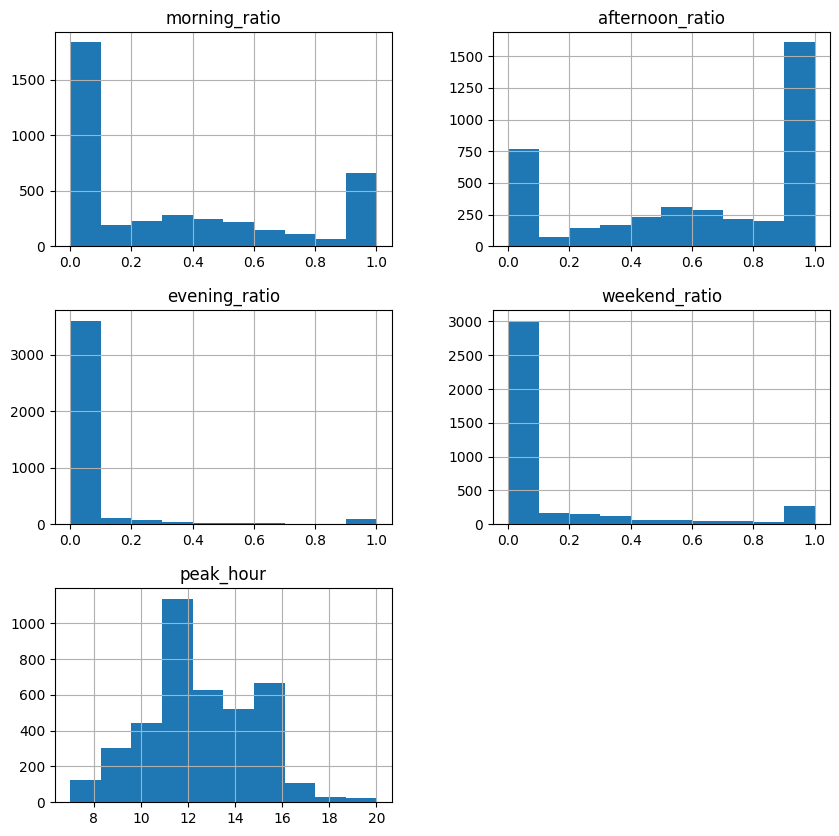

In [80]:
# plot histogram semua kolom
df_time_clean.hist(figsize=(10,10))

In [81]:
# 1) Define the relevant columns
cols = ["morning_ratio", "afternoon_ratio", "evening_ratio", "weekend_ratio", "peak_hour"]

# 2) Scale the dataset
scaler = StandardScaler()
df_scaled = df_time_clean.copy()
df_scaled[cols] = scaler.fit_transform(df_time_clean[cols])

# 3) Apply GMM-based binarization
df_binary = df_scaled.copy()

for col in cols:
    gmm = GaussianMixture(n_components=2, random_state=42)
    labels = gmm.fit_predict(df_scaled[[col]])
    means = gmm.means_.flatten()
    # reorder so 1 = high value, 0 = low value
    high_cluster = np.argmax(means)
    df_binary[col + "_binary"] = (labels == high_cluster).astype(int)

In [82]:
def assign_time_segment(row):
    ratios = {
        "Morning": row["morning_ratio"],
        "Afternoon": row["afternoon_ratio"],
        "Evening": row["evening_ratio"]
    }
    return max(ratios, key=ratios.get)

df_binary["dominant_period"] = df_time_clean[["morning_ratio", "afternoon_ratio", "evening_ratio"]].apply(assign_time_segment, axis=1)

In [83]:
final_df = df_binary[["dominant_period", "weekend_ratio_binary", "peak_hour_binary"]].copy()

encoder = OneHotEncoder(sparse_output=False)
period_encoded = encoder.fit_transform(final_df[["dominant_period"]])
period_df = pd.DataFrame(period_encoded,
                         columns=encoder.get_feature_names_out(["dominant_period"]),
                         index=final_df.index)
final_df = pd.concat([final_df.drop(columns=["dominant_period"]), period_df], axis=1)
final_df.head()

weekend_ratio_binary  peak_hour_binary  dominant_period_Afternoon  \
0                     0                 1                        1.0   
1                     0                 1                        0.0   
2                     0                 0                        0.0   
3                     0                 1                        1.0   
4                     0                 1                        1.0   

   dominant_period_Evening  dominant_period_Morning  
0                      0.0                      0.0  
1                      1.0                      0.0  
2                      0.0                      1.0  
3                      0.0                      0.0  
4                      0.0                      0.0

In [84]:
costs = []
K = range(2, 11)

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, random_state=42)
    km.fit(final_df.astype(int))
    costs.append(km.cost_)

for k, c in zip(K, costs):
    print(f"k={k}, cost={c}")

k=2, cost=2734.0
k=3, cost=1413.0
k=4, cost=1047.0
k=5, cost=643.0
k=6, cost=392.0
k=7, cost=502.0
k=8, cost=25.0
k=9, cost=15.0
k=10, cost=14.0


In [85]:
# Select binary + onehot columns
Seg_cols = [
    "weekend_ratio_binary",
    "peak_hour_binary",
    "dominant_period_Afternoon",
    "dominant_period_Evening",
    "dominant_period_Morning"
]

X = final_df[Seg_cols].astype(int)   # KModes requires integers

# Run KModes
km = KModes(n_clusters=5, init='Huang', n_init=10, random_state=42)
clusters = km.fit_predict(X)

# Add cluster labels back to dataframe
final_df["segment"] = clusters

final_df.head()

weekend_ratio_binary  peak_hour_binary  dominant_period_Afternoon  \
0                     0                 1                        1.0   
1                     0                 1                        0.0   
2                     0                 0                        0.0   
3                     0                 1                        1.0   
4                     0                 1                        1.0   

   dominant_period_Evening  dominant_period_Morning  segment  
0                      0.0                      0.0        4  
1                      1.0                      0.0        4  
2                      0.0                      1.0        2  
3                      0.0                      0.0        4  
4                      0.0                      0.0        4

In [86]:
cluster_profiles = (
    final_df.groupby("segment")[Seg_cols]
            .agg(lambda x: x.mode().iloc[0])
            .reset_index()
)
cluster_profiles

segment  weekend_ratio_binary  peak_hour_binary  dominant_period_Afternoon  \
0        0                     1                 1                        1.0   
1        1                     0                 0                        1.0   
2        2                     0                 0                        0.0   
3        3                     1                 0                        1.0   
4        4                     0                 1                        1.0   

   dominant_period_Evening  dominant_period_Morning  
0                      0.0                      0.0  
1                      0.0                      0.0  
2                      0.0                      1.0  
3                      0.0                      0.0  
4                      0.0                      0.0

In [87]:
persona_map = {
    0: "Weekend Leisure Shopper",
    1: "Weekday Quiet Buyer",
    2: "Night Flash Hunter",
    3: "Midday Flash Chaser",
    4: "Morning Routine Planner"
}

final_df["persona"] = final_df["segment"].map(persona_map)

In [88]:
final_df["persona"].value_counts()

persona
Night Flash Hunter         1209
Weekday Quiet Buyer         965
Morning Routine Planner     955
Midday Flash Chaser         477
Weekend Leisure Shopper     376
Name: count, dtype: int64

#### **Assign to dataset**

In [89]:
# assign kolom persona ke global data
df_global = df_global.assign(Time_cluster = final_df['persona'])
df_global.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  share_Bakelite Alarm Clocks  \
0        260.636268         23.714286                     0.050713   
1         19.760904          2.000000                     0.000000   
2          0.000000         58.000000                     0.000000   
3          0.000000         16.000000                     0.000000   
4         59.702145          9.428571                     0.000000   

   share_Cake Cases & Baking Items  share_Christmas Paper Craft Kits  \
0                         0.185948                          0.049657   
1                         0.685714                          0.000000   
2                         0.084130                          0.036329   
3                         0.000000                          0.061224   
4                         0.128000                          0.030000   

   share_Dolly Girl (Lunch & Accesories)  ...  monthly_txs_mean  \
0                               0.101426  ...              1.00   
1                               0.000000  ...              1.00   
2                               0.118547  ...              1.00   
3                               0.173469  ...              1.00   
4                               0.206000  ...              1.75   

   monthly_txs_std  Outlier_Scores  Is_Outlier  Basket_cluster  \
0         0.000000               1           0               1   
1         0.000000               1           0               0   
2         0.000000               1           0               1   
3         0.000000               1           0               1   
4         0.957427               1           0               0   

                             Category persona  frequency_segment  \
0                            Variety Explorer                  2   
1  Cake Cases & Baking Items Dominant Shopper                  1   
2                            Variety Explorer                  0   
3                            Variety Explorer                  0   
4                            Variety Explorer                  2   

   recency_segment  Spend_cluster             Time_cluster  
0                0             -1  Morning Routine Planner  
1                4              1  Morning Routine Planner  
2                0             -1       Night Flash Hunter  
3                4              3  Morning Routine Planner  
4                2             -1  Morning Routine Planner  

[5 rows x 61 columns]

In [90]:
df_time_clean = df_time_clean.assign(Time_cluster = final_df['persona'])
df_time_clean.head()

morning_ratio  afternoon_ratio  evening_ratio  weekend_ratio  peak_hour  \
0       0.240964         0.759036       0.000000            0.0         14   
1       0.333333         0.000000       0.666667            0.0         19   
2       1.000000         0.000000       0.000000            0.0          9   
3       0.000000         1.000000       0.000000            0.0         16   
4       0.000000         1.000000       0.000000            0.0         14   

              Time_cluster  
0  Morning Routine Planner  
1  Morning Routine Planner  
2       Night Flash Hunter  
3  Morning Routine Planner  
4  Morning Routine Planner

## **Profiling & Visualization**

### **Basket**

In [91]:
df_basket_clean.head()

CustomerID  avg_basket_size  basket_std  avg_basket_value  \
0       12347       270.428571  131.817876        473.532857   
1       12348        46.666667   42.770706         30.066667   
2       12349       523.000000    0.000000        999.150000   
3       12350       196.000000    0.000000        294.400000   
4       12352        71.428571   32.974016        161.562857   

   basket_value_std  avg_unique_items  Basket_cluster  
0        260.636268         23.714286               1  
1         19.760904          2.000000               0  
2          0.000000         58.000000               1  
3          0.000000         16.000000               1  
4         59.702145          9.428571               0

In [92]:
features = ['avg_basket_size', 'basket_std', 'avg_basket_value', 'basket_value_std', 'avg_unique_items']


cluster_stats = df_basket_clean.groupby("Basket_cluster")[['avg_basket_size', 'avg_basket_value', 'avg_unique_items']].agg(
    ["mean", "median", "std", "min", "max", "count"]
)

cluster_stats

avg_basket_size                                            \
                          mean      median        std   min    max count   
Basket_cluster                                                             
0                    55.740401   54.647059  28.006874   1.0  172.0  1391   
1                   189.253738  165.000000  99.308951  50.4  748.0  2591   

               avg_basket_value                                             \
                           mean   median         std    min      max count   
Basket_cluster                                                               
0                    106.430759  105.255   50.374771   0.00   404.40  1391   
1                    301.857246  268.048  150.004279  82.02  1274.16  2591   

               avg_unique_items                                          
                           mean     median        std  min    max count  
Basket_cluster                                                           
0                      7.313344   6.333333   4.978023  1.0   31.0  1391  
1                     25.381338  20.000000  16.756168  5.0  135.0  2591

In [93]:
df_basket_clean["Basket_cluster"] = df_basket_clean["Basket_cluster"].replace({
    0: "Small Basket Shopper",
    1: "Big Basket Shopper"
})

df_global["Basket_cluster"] = df_global["Basket_cluster"].replace({
    0: "Small Basket Shopper",
    1: "Big Basket Shopper"
})

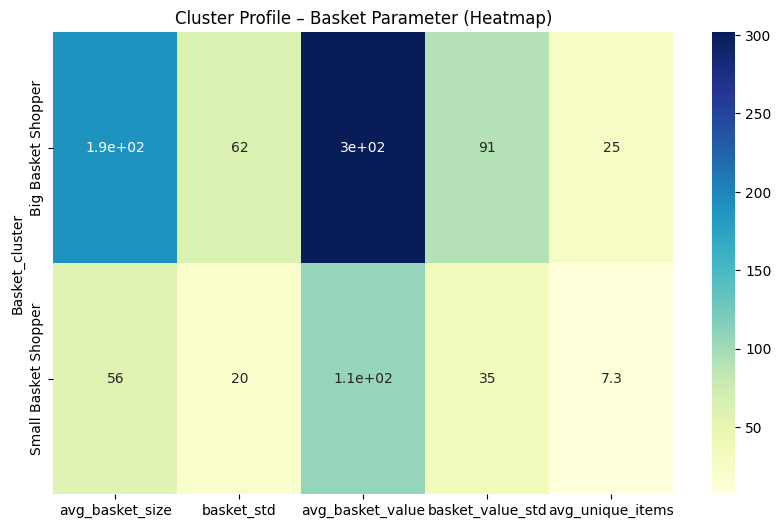

In [94]:
cluster_profile = df_basket_clean.groupby('Basket_cluster')[features].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profile, annot=True, cmap='YlGnBu')
plt.title("Cluster Profile – Basket Parameter (Heatmap)")
plt.show()

In [95]:
def compute_radar_values(row, feature_list):
    values = row[feature_list].values
    values = np.append(values, values[0])
    return values

def radar_side_by_side(cluster_profile, feature_list):
    n_clusters = cluster_profile.shape[0]
    n_features = len(feature_list)

    angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False)
    angles = np.append(angles, angles[0])

    # --- menentukan jumlah kolom ---
    n_cols = 2 if n_clusters > 1 else 1
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        subplot_kw=dict(polar=True)
    )

    # handle kalau radar cuma satu cluster (axes bukan array)
    axes = np.array(axes).reshape(-1)

    for idx, (cluster_id, row) in enumerate(cluster_profile.iterrows()):
        ax = axes[idx]

        values = compute_radar_values(row, feature_list)

        # plot
        ax.plot(angles, values, linewidth=2)
        ax.fill(angles, values, alpha=0.25)

        ax.set_thetagrids(np.degrees(angles[:-1]), feature_list)
        ax.text(0.5, -0.25, f"Cluster {cluster_id}",
        transform=ax.transAxes,
        ha='center', va='center',
        fontsize=14)

    # matikan subplot sisa kalau jumlah cluster tidak genap
    for j in range(idx + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Radar Chart per Cluster", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

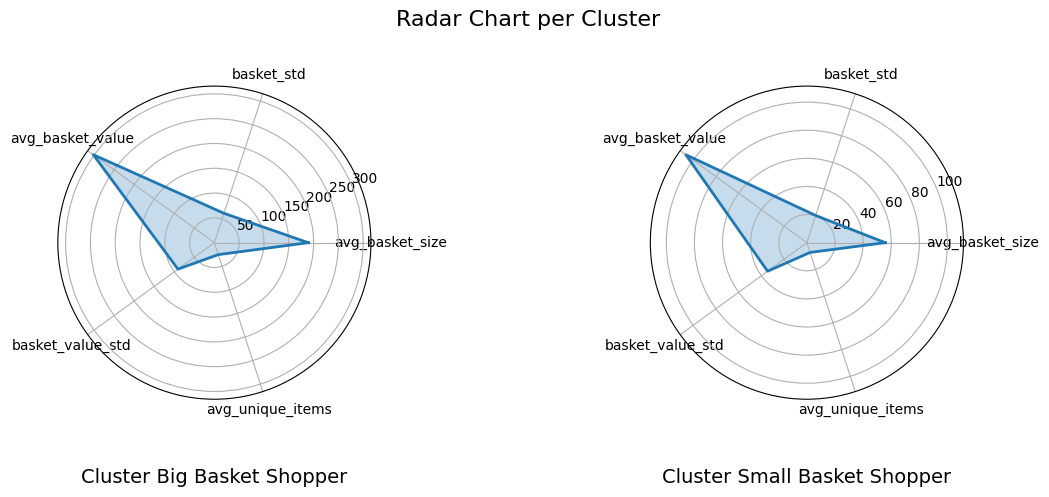

In [96]:
radar_side_by_side(cluster_profile, features)

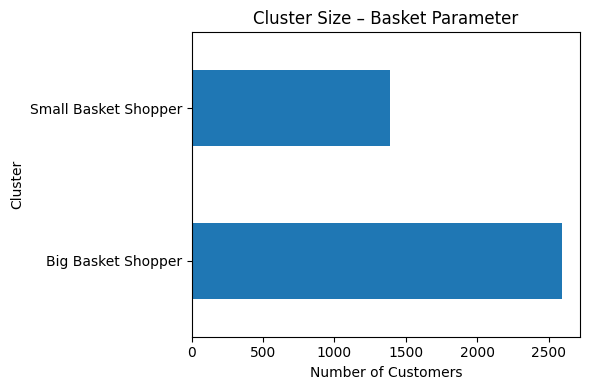

In [97]:
df_basket_clean['Basket_cluster'].value_counts().sort_index().plot(
    kind='barh',
    figsize=(6,4),
    title="Cluster Size – Basket Parameter"
)

plt.xlabel("Number of Customers")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

### **Recency**

In [98]:
cluster_profile = df_recency_clean.drop('CustomerID', axis = 1).groupby("recency_segment").mean(numeric_only=True)

print("===== CLUSTER PROFILING ===")
print(cluster_profile)

print("\nMaka interpretasinya adalah sebagai berikut:")
print("Cluster 0 : Highly Active Customers (Loyal / Frequent Shoppers)")
print("Cluster 1 : At-Risk Customers (Mulai jarang belanja, perlu aktivasi kembali)")
print("Cluster 2 : Regular Active Customers (Aktif tapi tidak seintens cluster 0)")
print("Cluster 3 : Hibernating Customers (Lama tidak kembali, kemungkinan churn)")
print("Cluster 4 : Lost Customers (Sangat lama tidak bertransaksi, perlu reaktivasi kuat)")


===== CLUSTER PROFILING ===
                 days_since_last_purchase  time_since_first_purchase  \
recency_segment                                                        
0                                8.338506                 215.502425   
1                               85.434959                 190.645325   
2                               32.832305                 187.956790   
3                              163.347368                 224.831579   
4                              268.018634                 286.663354   

                 avg_recency  recency_rank  recency_zscore  
recency_segment                                             
0                   3.548931      9.338506       -0.832057  
1                   3.285412     86.434959       -0.060297  
2                   3.711212     33.832305       -0.586866  
3                   2.734140    163.405263        0.719630  
4                   1.042312    258.063354        1.767421  

Maka interpretasinya adalah sebagai ber

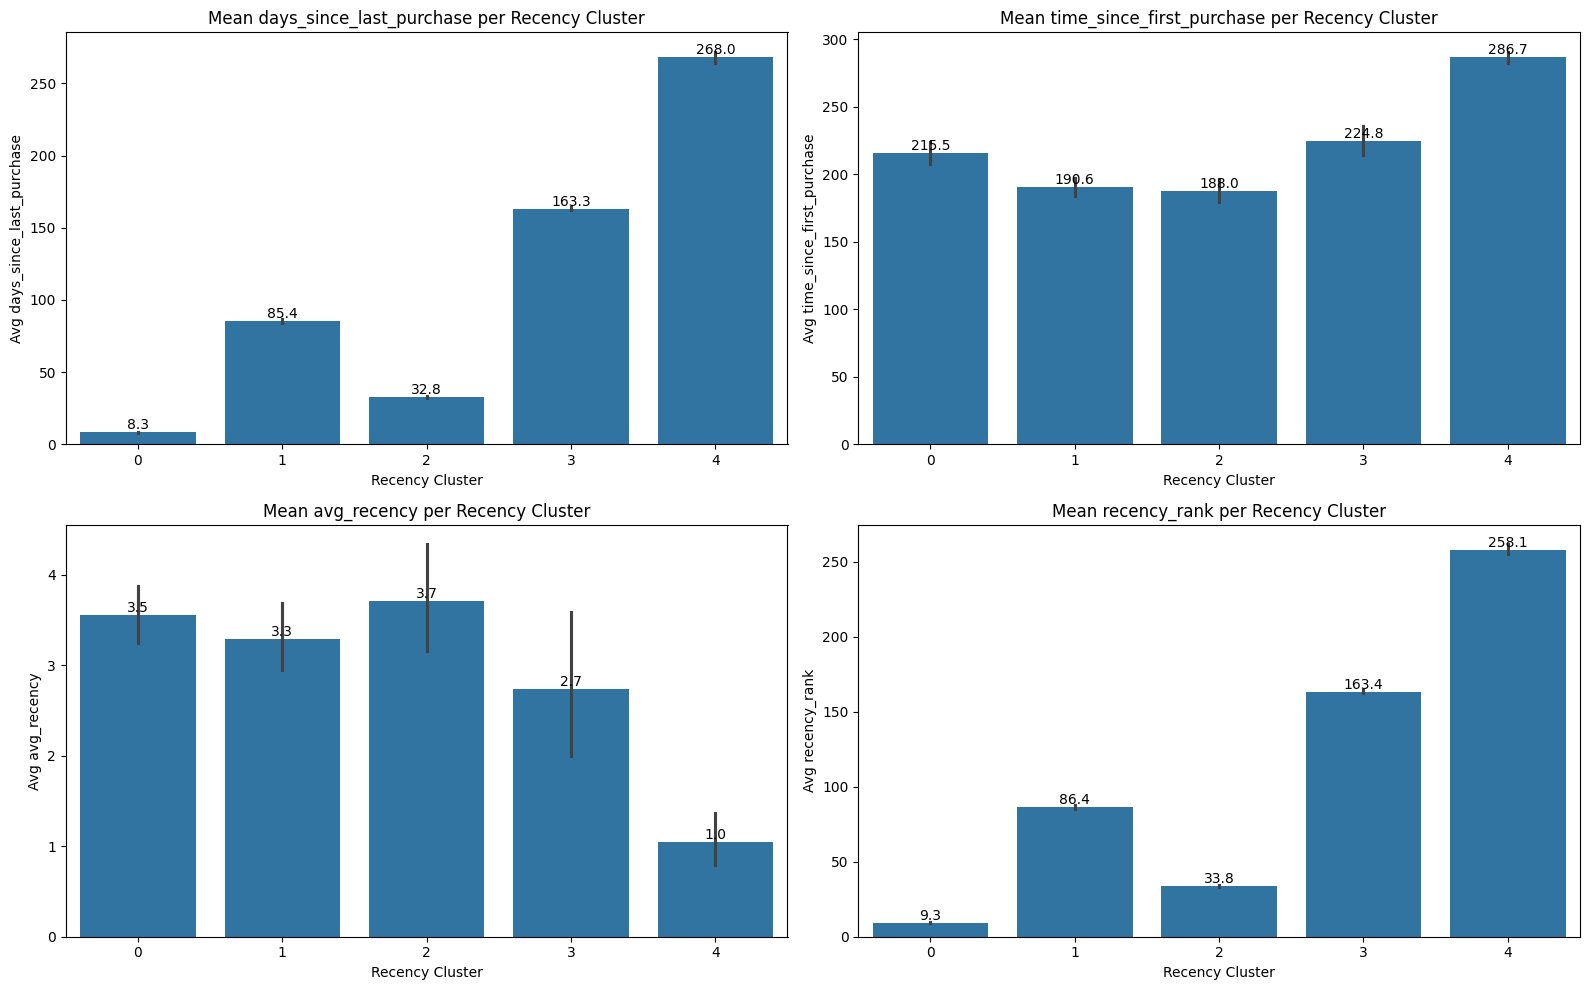


Interpretasi Recency per Cluster:

Cluster 0 : Pembelian terbaru dan frekuensi tinggi → Very Active Customers
Cluster 1 : Mulai jarang beli → At-Risk Customers
Cluster 2 : Masih aktif namun tidak seintens Cluster 0 → Active Customers
Cluster 3 : Lama tidak kembali → Hibernating Customers
Cluster 4 : Sangat lama tidak beli → Lost Customers



In [99]:
# Define the numerical variables to plot for recency profiling
recency_vars = ['days_since_last_purchase', 'time_since_first_purchase', 'avg_recency', 'recency_rank']

plt.figure(figsize=(16,10))

for i, var in enumerate(recency_vars, 1):
    plt.subplot(2, 2, i)
    ax = sns.barplot(
        data=df_recency_clean.reset_index(), # Use df_recency_clean and reset_index if 'recency_segment' is the index
        x='recency_segment',
        y=var,
        estimator='mean'
    )
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f")
    plt.title(f"Mean {var} per Recency Cluster")
    plt.xlabel("Recency Cluster")
    plt.ylabel(f"Avg {var}")

plt.tight_layout()
plt.show()

print("""
Interpretasi Recency per Cluster:

Cluster 0 : Pembelian terbaru dan frekuensi tinggi → Very Active Customers
Cluster 1 : Mulai jarang beli → At-Risk Customers
Cluster 2 : Masih aktif namun tidak seintens Cluster 0 → Active Customers
Cluster 3 : Lama tidak kembali → Hibernating Customers
Cluster 4 : Sangat lama tidak beli → Lost Customers
""")



In [100]:
df_recency_clean["recency_segment"] = df_recency_clean["recency_segment"].replace({
    0: "Very Active Customers",
    1: "At-Risk Customers",
    2: "Active Customers",
    3: "Hibernating Customers",
    4: "Lost Customers"
})

df_global["recency_segment"] = df_global["recency_segment"].replace({
    0: "Very Active Customers",
    1: "At-Risk Customers",
    2: "Active Customers",
    3: "Hibernating Customers",
    4: "Lost Customers"
})

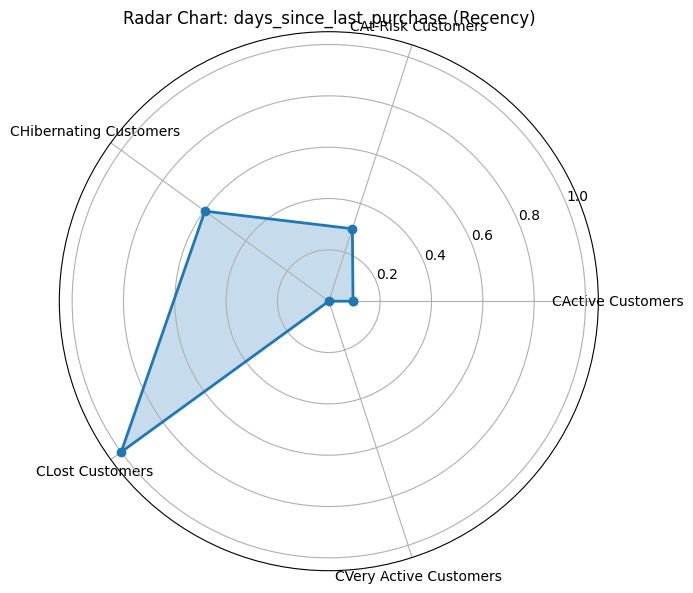

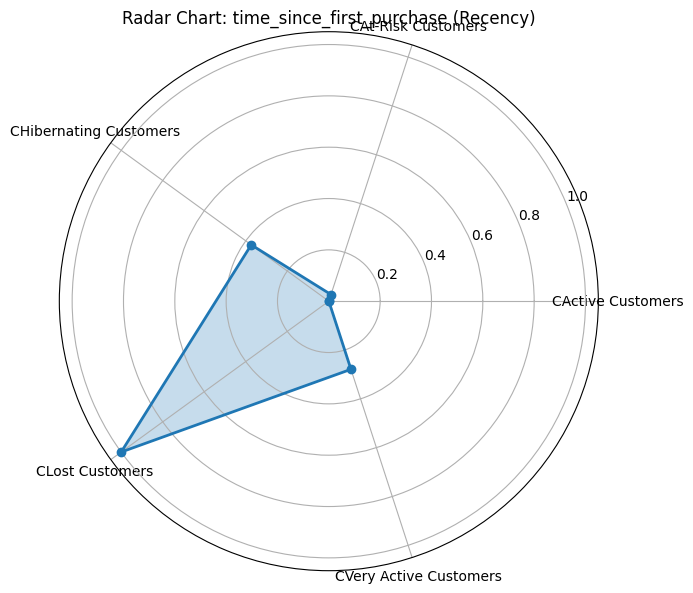

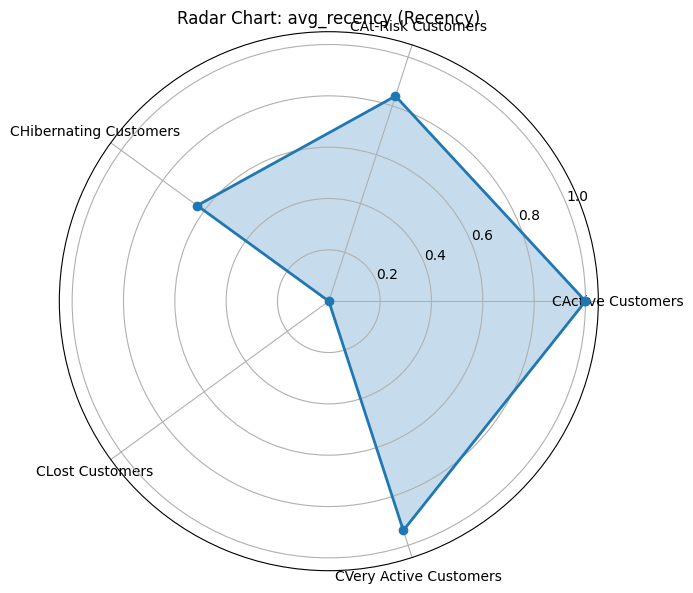

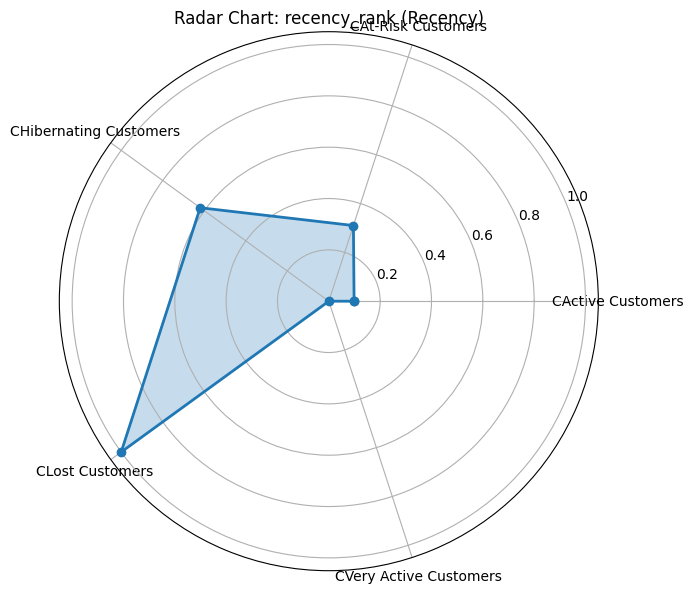

In [101]:
# Profiling Recency (mean per cluster)
recency_profile = df_recency_clean.groupby('recency_segment')[[ # Changed df to df_recency_clean
    'days_since_last_purchase',
    'time_since_first_purchase',
    'avg_recency',
    'recency_rank'
]].mean()

# Normalisasi untuk radar
scaler = MinMaxScaler()
profile_scaled = scaler.fit_transform(recency_profile)
profile_scaled = pd.DataFrame(profile_scaled,
                              index=recency_profile.index,
                              columns=recency_profile.columns)

# Fungsi radar per satu variabel
def radar_per_feature(feature):
    values = profile_scaled[feature].tolist()
    clusters = recency_profile.index.tolist()

    N = len(clusters)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    values += values[:1]

    plt.figure(figsize=(7,7))
    plt.polar(angles, values, marker='o', linewidth=2)
    plt.fill(angles, values, alpha=0.25)

    plt.xticks(angles[:-1], [f"C{c}" for c in clusters])
    plt.title(f"Radar Chart: {feature} (Recency)")
    plt.show()

# --- Generate radar chart per feature ---
for col_name in profile_scaled.columns:
    radar_per_feature(col_name)

### **Frequency**

In [102]:
frequency_profile = df_frequency_clean.drop('CustomerID', axis = 1).groupby('frequency_segment').mean()
display(frequency_profile)


purchase_frequency  unique_visit_days  purchase_per_month  \
frequency_segment                                                              
0                            1.346667           1.329333            1.043556   
1                            3.776062           3.587838            1.186133   
2                            7.447423           6.942268            1.326656   
3                           14.838863          13.668246            1.583566   

                   order_interval_mean  order_interval_std  
frequency_segment                                           
0                             2.164757            8.129011  
1                             4.839967           19.505441  
2                             3.105936           13.339480  
3                             2.210189            8.262269

In [103]:
print("===== INTERPRETASI FREQUENCY SEGMENT (MULTIDIMENSIONAL) =====\n")

Q1 = frequency_profile['purchase_frequency'].quantile(0.25)
Q2 = frequency_profile['purchase_frequency'].quantile(0.50)
Q3 = frequency_profile['purchase_frequency'].quantile(0.75)

for segment, row in frequency_profile.iterrows():
    freq = row['purchase_frequency']
    visits = row['unique_visit_days']
    monthly = row['purchase_per_month']
    interval_mean = row['order_interval_mean']
    interval_std = row['order_interval_std']

    # --------------------------
    # FREQUENCY CATEGORY
    # --------------------------
    if freq >= Q3:
        freq_label = "💎 High Frequency Buyers"
        freq_desc = "Sering belanja & sangat aktif."
    elif freq >= Q2:
        freq_label = "📈 Medium Frequency Buyers"
        freq_desc = "Aktif namun tidak seintens segmen premium."
    elif freq >= Q1:
        freq_label = "⚠ Low Frequency Buyers"
        freq_desc = "Belanja sesekali, tidak rutin."
    else:
        freq_label = "🧊 Very Low Frequency / Dormant"
        freq_desc = "Jarang belanja dan berpotensi churn."

    # --------------------------
    # ENGAGEMENT LEVEL (unique days)
    # --------------------------
    if visits > monthly * 3:
        engage = "🔥 Sangat Tinggi"
    elif visits > monthly * 2:
        engage = "⭐ Tinggi"
    elif visits > monthly:
        engage = "🙂 Normal"
    else:
        engage = "😴 Rendah"

    # --------------------------
    # SHOPPING CONSISTENCY (interval)
    # --------------------------
    if interval_mean <= 3:
        pace = "⚡ Fast Buying Cycle"
    elif interval_mean <= 7:
        pace = "⏳ Medium Buying Cycle"
    else:
        pace = "🐌 Slow Buying Cycle"

    if interval_std <= 5:
        consistency = "Stabil"
    else:
        consistency = "Tidak Stabil"

    # --------------------------
    # STRATEGY (kombinasi multidimensi)
    # --------------------------
    if freq >= Q3 and engage.startswith("🔥"):
        strategy = "Berikan VIP loyalty, early access, upsell high-value."
    elif freq >= Q2 and "Fast" in pace:
        strategy = "Rekomendasikan produk pelengkap & cross-sell rutin."
    elif freq < Q1 and pace == "🐌 Slow Buying Cycle":
        strategy = "Reactivation campaign + diskon come-back."
    else:
        strategy = "Promo personalisasi untuk meningkatkan engagement."

    # --------------------------
    # OUTPUT FINAL
    # --------------------------
    print(f"\n=== Segment {segment} ===")
    print(f"Kategori Utama     : {freq_label} → {freq_desc}")
    print(f"Engagement Level   : {engage}")
    print(f"Buying Cycle       : {pace} ({consistency})")
    print(f"Rata2 Interval     : {interval_mean:.2f} hari, Variasi: {interval_std:.2f}")
    print(f"Monthly Activity   : {monthly:.2f} beli/bln")
    print(f"Strategi Marketing : {strategy}")

===== INTERPRETASI FREQUENCY SEGMENT (MULTIDIMENSIONAL) =====


=== Segment 0 ===
Kategori Utama     : 🧊 Very Low Frequency / Dormant → Jarang belanja dan berpotensi churn.
Engagement Level   : 🙂 Normal
Buying Cycle       : ⚡ Fast Buying Cycle (Tidak Stabil)
Rata2 Interval     : 2.16 hari, Variasi: 8.13
Monthly Activity   : 1.04 beli/bln
Strategi Marketing : Promo personalisasi untuk meningkatkan engagement.

=== Segment 1 ===
Kategori Utama     : ⚠ Low Frequency Buyers → Belanja sesekali, tidak rutin.
Engagement Level   : 🔥 Sangat Tinggi
Buying Cycle       : ⏳ Medium Buying Cycle (Tidak Stabil)
Rata2 Interval     : 4.84 hari, Variasi: 19.51
Monthly Activity   : 1.19 beli/bln
Strategi Marketing : Promo personalisasi untuk meningkatkan engagement.

=== Segment 2 ===
Kategori Utama     : 📈 Medium Frequency Buyers → Aktif namun tidak seintens segmen premium.
Engagement Level   : 🔥 Sangat Tinggi
Buying Cycle       : ⏳ Medium Buying Cycle (Tidak Stabil)
Rata2 Interval     : 3.11 hari, Varia

In [104]:
df_frequency_clean["frequency_segment"] = df_frequency_clean["frequency_segment"].replace({
    0: "Very Low Frequency",
    1: "Low Frequency Buyers",
    2: "Medium Frequency Buyers",
    3: "High Freqeuency Buyers"
})

df_global["frequency_segment"] = df_global["frequency_segment"].replace({
    0: "Very Low Frequency",
    1: "Low Frequency Buyers",
    2: "Medium Frequency Buyers",
    3: "High Freqeuency Buyers"
})

In [105]:
df_frequency_clean.head()

CustomerID  purchase_frequency  unique_visit_days  purchase_per_month  \
0       12347                   7                  7                1.00   
1       12348                   3                  3                1.00   
2       12349                   1                  1                1.00   
3       12350                   1                  1                1.00   
4       12352                   7                  7                1.75   

   order_interval_mean  order_interval_std        frequency_segment  
0             2.193939           11.778907  Medium Frequency Buyers  
1            21.800000           31.799371     Low Frequency Buyers  
2             0.000000            0.000000       Very Low Frequency  
3             0.000000            0.000000       Very Low Frequency  
4             3.969231           22.870539  Medium Frequency Buyers

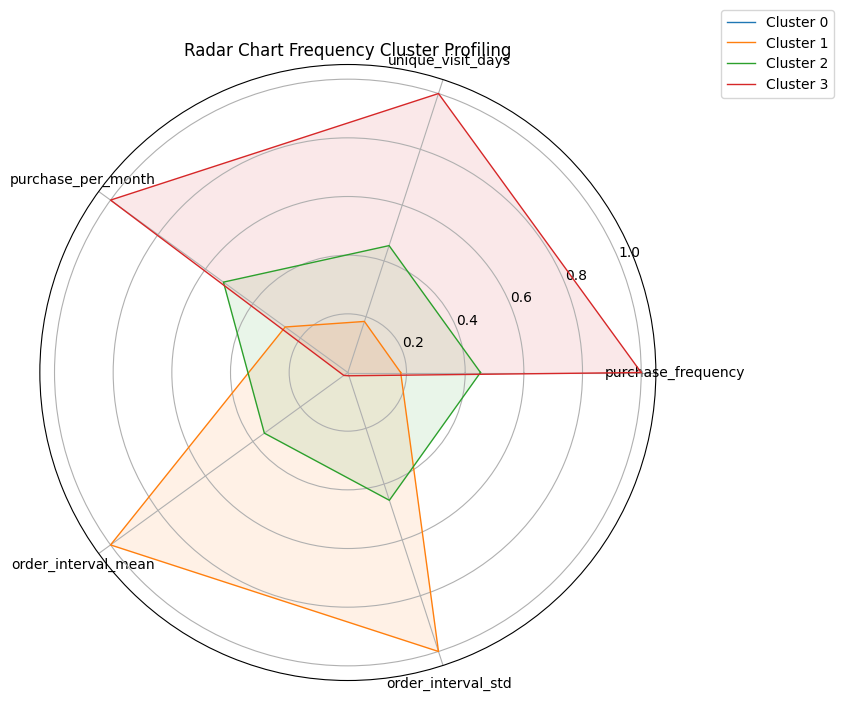

In [106]:
# Data untuk radar chart
profile = frequency_profile.copy()
profile_minmax = (profile - profile.min()) / (profile.max() - profile.min())

categories = list(profile_minmax.columns)
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

plt.figure(figsize=(10,8))

for idx, row in profile_minmax.iterrows():
    values = row.tolist()
    values += values[:1]

    plt.polar(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {idx}')
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title("Radar Chart Frequency Cluster Profiling")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


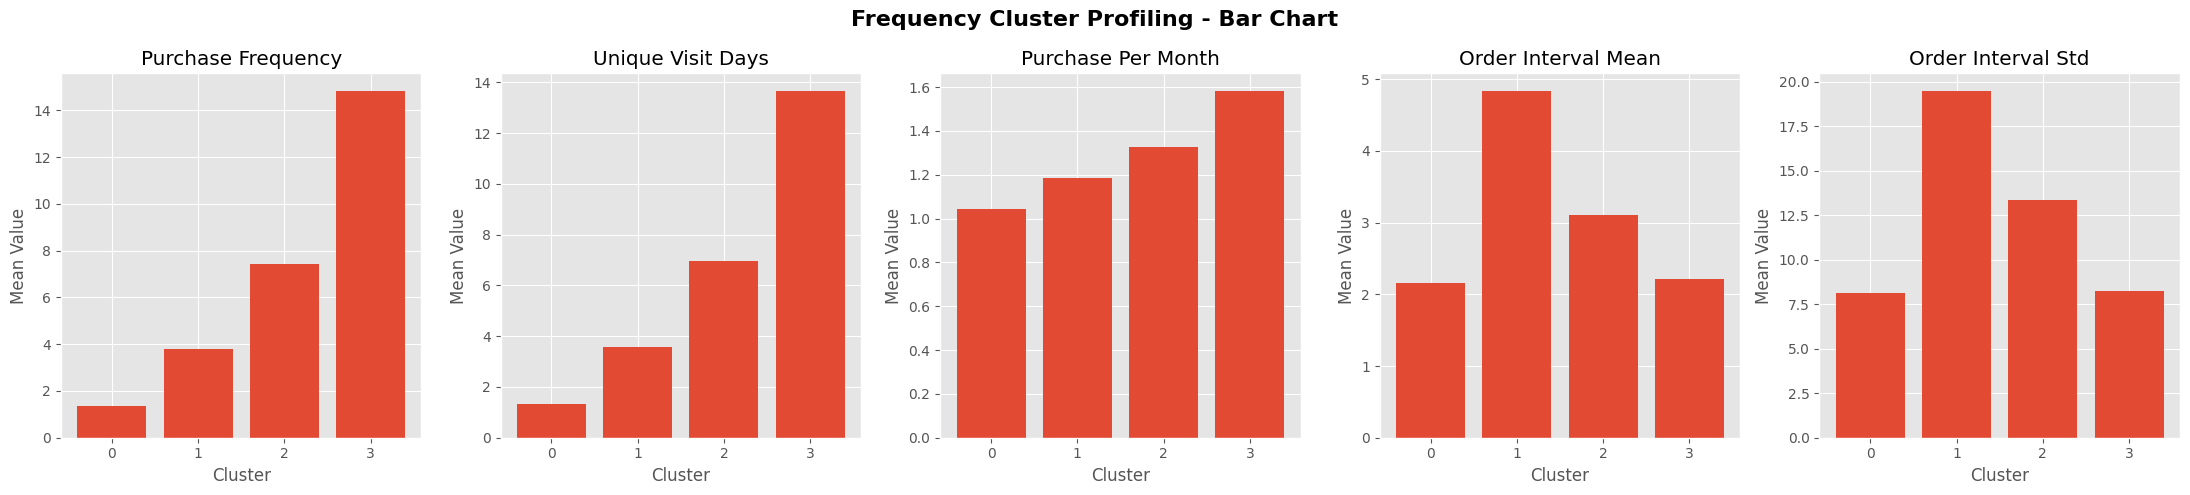

In [107]:
# Untuk akses data cluster frequency
profile = frequency_profile.copy()
freq_features = ['purchase_frequency',	'unique_visit_days',	'purchase_per_month',	'order_interval_mean',	'order_interval_std']
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=1, ncols=len(freq_features), figsize=(22,5))

for i, feature in enumerate(freq_features):
    axes[i].bar(profile.index, profile[feature])
    axes[i].set_title(feature.replace("_", " ").title())
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel("Mean Value")
    axes[i].set_xticks(profile.index)

plt.suptitle("Frequency Cluster Profiling - Bar Chart", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


### **SPEND**

In [108]:
features = df_spend_clean.drop(columns=["CustomerID", "Spend_cluster"])
cluster_labels = df_spend_clean["Spend_cluster"]

In [109]:
cluster_profile = df_spend_clean.drop('CustomerID', axis = 1).groupby("Spend_cluster").mean(numeric_only=True)

print("===== CLUSTER PROFILING =====")
print(cluster_profile)

===== CLUSTER PROFILING =====
               total_spend  total_transactions  total_items  avg_order_value  \
Spend_cluster                                                                  
-1             1852.889357            6.854758  1093.359766       344.224862   
 1              695.357775            3.616711   429.778515       191.930124   
 2              387.220838            2.000000   242.662011       193.610419   
 3              178.413661            1.000000   112.398782       178.413661   

               max_order_value  std_order_value  spend_velocity  spend_trend  
Spend_cluster                                                                 
-1                  535.290417       129.137999      410.951341    -0.098107  
 1                  299.506777        95.636739      227.267922    -6.100004  
 2                  249.419721        78.926271      215.574078   -12.866061  
 3                  178.413661         0.000000      178.413661     0.000000  


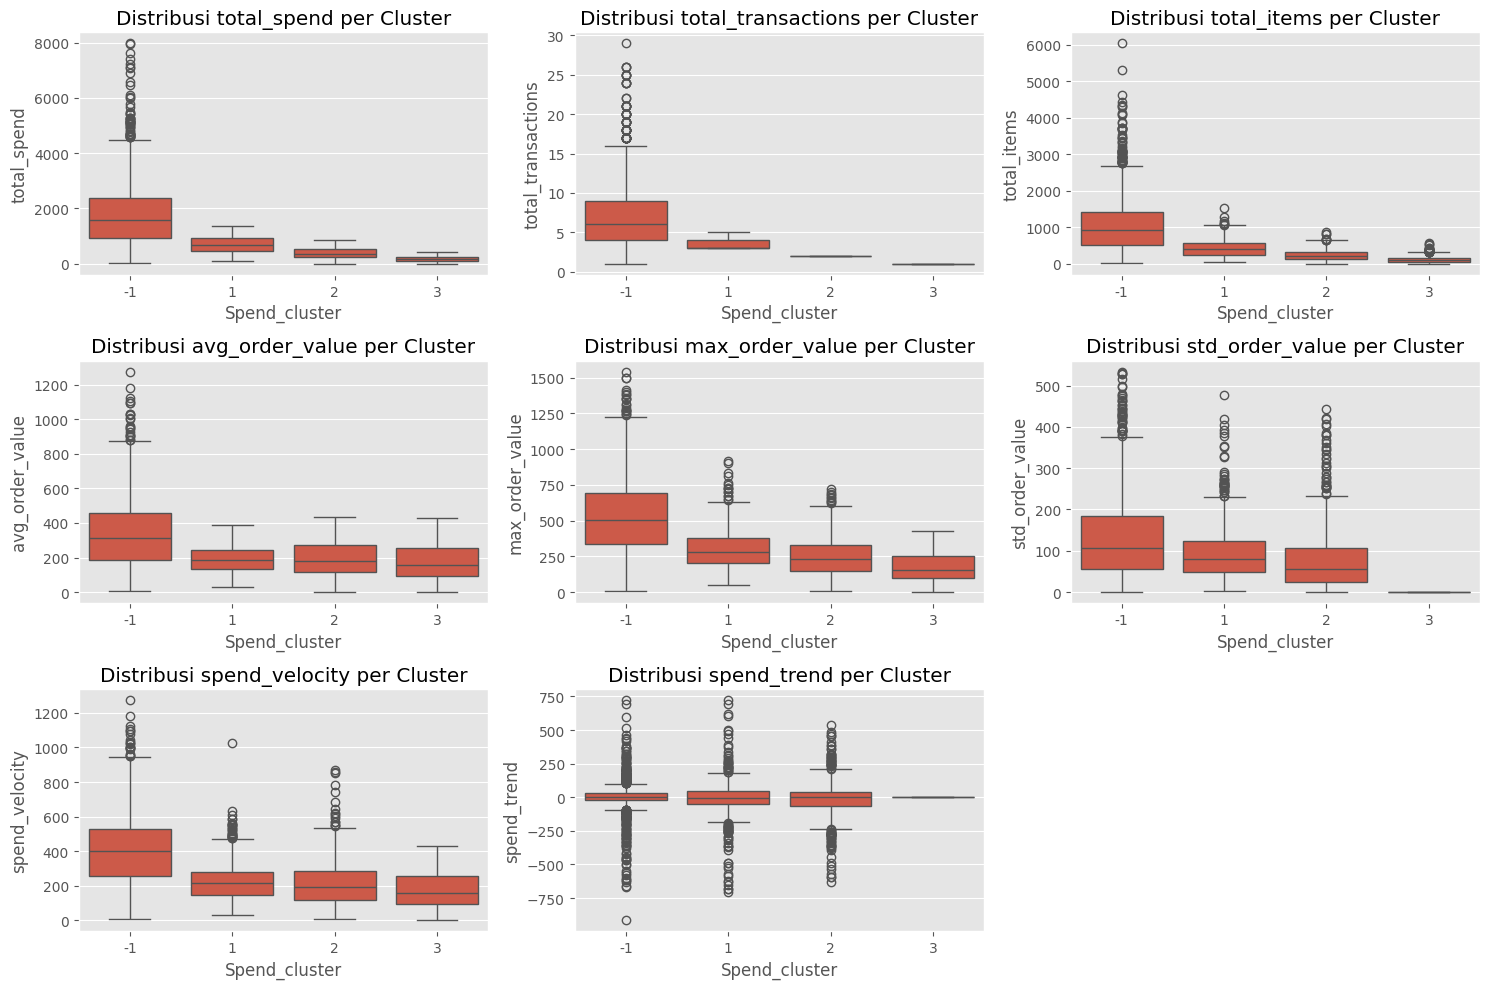

In [110]:
num_cols = features.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=cluster_labels, y=df_spend_clean[col])
    plt.title(f"Distribusi {col} per Cluster")
plt.tight_layout()
plt.show()

Interpretasi :
Cluster -1 : Power Spender
Cluster 1 : Average Spender
Cluster 2 : Low-Moderate Spender
Cluster 3 : Single Transaction Mid Spender

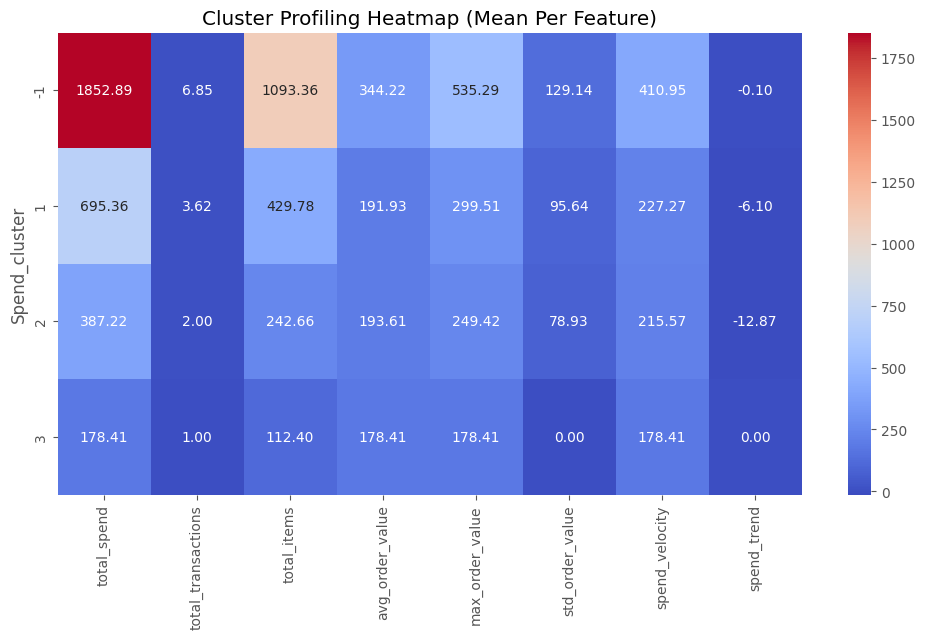

In [111]:
plt.figure(figsize=(12,6))
sns.heatmap(cluster_profile, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Cluster Profiling Heatmap (Mean Per Feature)")
plt.show()

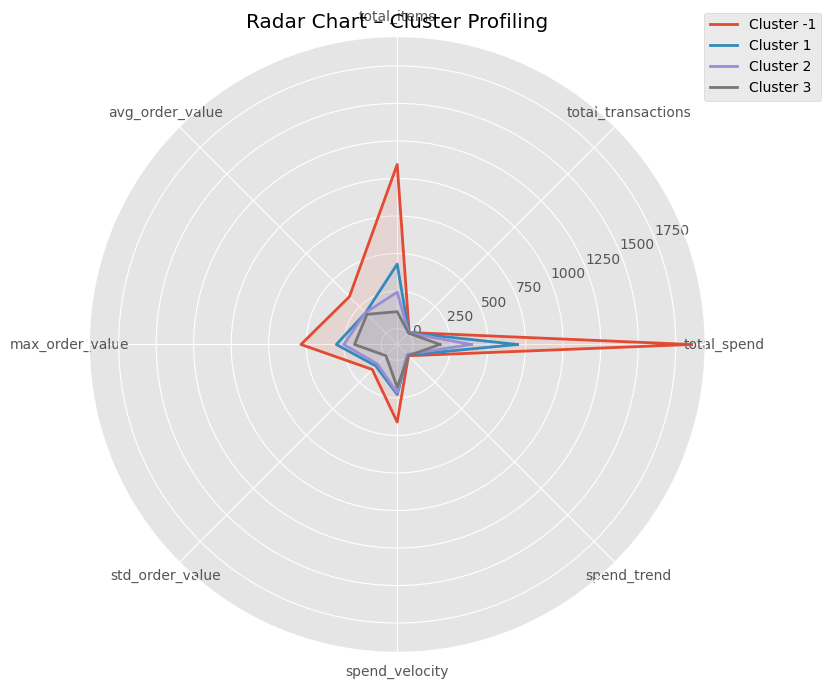

In [112]:
features_radar = cluster_profile.columns
num_vars = len(features_radar)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))

for cluster in cluster_profile.index:
    values = cluster_profile.loc[cluster].tolist()
    values += values[:1]

    plt.polar(angles, values, label=f"Cluster {cluster}", linewidth=2)
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], features_radar)
plt.title("Radar Chart – Cluster Profiling")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

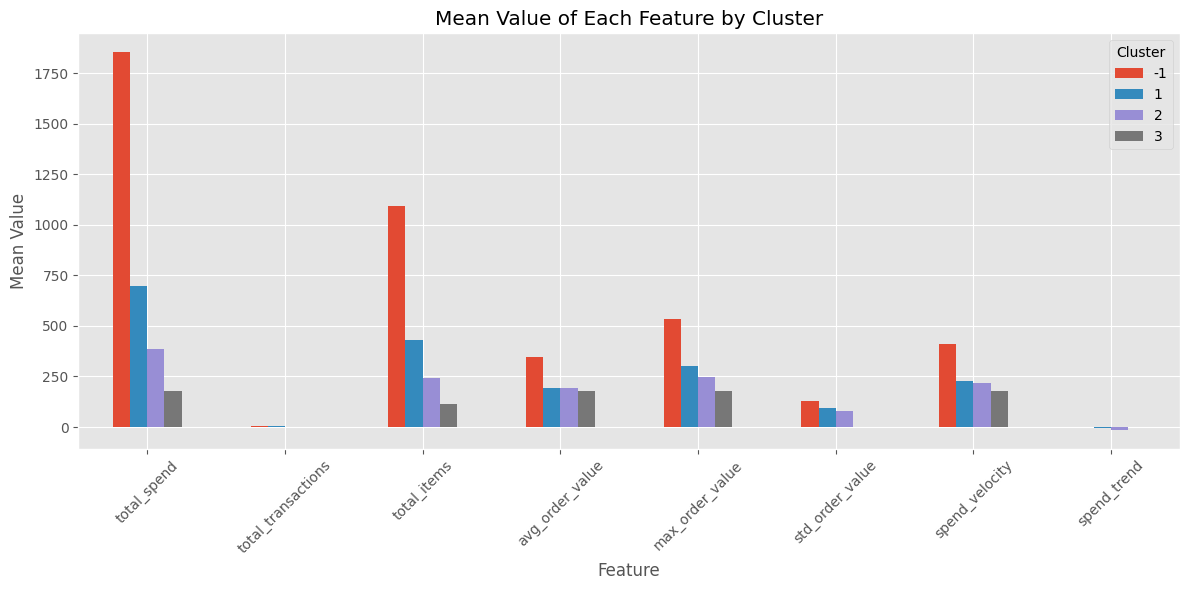

In [113]:
cluster_profile.T.plot(kind="bar", figsize=(12,6))
plt.title("Mean Value of Each Feature by Cluster")
plt.xlabel("Feature")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [114]:
df_spend_clean["Spend_cluster"] = df_spend_clean["Spend_cluster"].replace({
    -1: "Power Spender",
    1: "Average Spender",
    2: "Low-Moderate Spender",
    3: "Single Transaction Mid Spender"
})

df_global["Spend_cluster"] = df_global["Spend_cluster"].replace({
    -1: "Power Spender",
    1: "Average Spender",
    2: "Low-Moderate Spender",
    3: "Single Transaction Mid Spender"
})

In [115]:
df_spend_clean.head()

CustomerID  total_spend  total_transactions  total_items  avg_order_value  \
0       12347      3314.73                   7         1893       473.532857   
1       12348        90.20                   3          140        30.066667   
2       12349       999.15                   1          523       999.150000   
3       12350       294.40                   1          196       294.400000   
4       12352      1130.94                   7          500       161.562857   

   max_order_value  std_order_value  spend_velocity  spend_trend  \
0           982.40       260.636268      473.532857      -6.0725   
1            52.80        19.760904       30.066667     -17.9000   
2           999.15         0.000000      999.150000       0.0000   
3           294.40         0.000000      294.400000       0.0000   
4           228.40        59.702145      282.735000      -4.9020   

                    Spend_cluster  
0                   Power Spender  
1                 Average Spender  
2                   Power Spender  
3  Single Transaction Mid Spender  
4                   Power Spender

## **Dashboard**

In [116]:
dashboard_features = [
    'CustomerID', 'avg_basket_size', 'basket_std', 'avg_basket_value', 'basket_value_std', 'avg_unique_items',
    'days_since_last_purchase', 'time_since_first_purchase', 'avg_recency', 'recency_rank',
    'purchase_frequency',	'unique_visit_days',	'purchase_per_month',
    'total_spend',  'total_transactions',  'total_items', 'avg_order_value',
    'share_Bakelite Alarm Clocks', 'share_Cake Cases & Baking Items', 'share_Christmas Paper Craft Kits',
    'share_Dolly Girl (Lunch & Accesories)', 'share_Hanging Light Decor',
    'share_Hot Water Bottle', 'share_Kitchen Tins & Pantry Set',
    'share_Lunch Bags', 'share_Metal Signs', 'share_Party Buntings',
    'share_Pink/Charlotte Bags', 'share_Regency Teacup & Saucer',
    'share_Retrospot Red Collection', 'share_Vintage Jumbo Bags',
    'share_Wicker Heart Decor', 'top_category_1', 'top_category_2',
    'category_diversity', 'category_entropy',
    'morning_ratio', 'afternoon_ratio', 'evening_ratio', 'weekend_ratio',
    'peak_hour', 'Basket_cluster', 'Category persona', 'frequency_segment', 'recency_segment', 'Spend_cluster', 'Time_cluster'
]

In [117]:
df_dashboard = df_global[dashboard_features].copy()

In [118]:
df_dashboard.to_csv('dashboard.csv', index = False)

## **Recommendation System**

In [119]:
# Load raw dataset
url = 'https://drive.google.com/uc?id=1PkyPBg-ZeCzcqnmVImlEzJqbmIa9z8ah'
df = pd.read_csv(url, sep=';', encoding='latin-1')

df['Revenue'] = df['Quantity'] * df['UnitPrice']
df = df[df['Revenue'] > 0]

spend_df = df_spend_clean.copy()
cat_df = df_category_clean.copy()
freq_df = df_frequency_clean.copy()

### **Product Cleaning**

In [120]:
BAD_PATTERNS = [
    r'\bmanual\b', r'\bpostage\b', r'\bpost\b', r'\bshipping\b',
    r'\badjustment\b', r'\bdiscount\b', r'\breturn\b', r'\bamazon\b',
    r'^\d+$'
]

def is_valid_product(name):
    if not isinstance(name, str):
        return False
    s = name.lower()

    for p in BAD_PATTERNS:
        if re.search(p, s):
            return False

    if len(s) < 3:
        return False

    return True

df = df[df["Description"].apply(is_valid_product)].copy()

### **Top Product Per Category**

In [121]:
top_products = (
    df.groupby("Description")["Revenue"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

product_price = df.groupby("Description")["UnitPrice"].mean().to_dict()

customer_history = df.groupby("CustomerID")["Description"].apply(set).to_dict()

### **Association Rules**

In [122]:
basket = df.groupby("InvoiceNo")["Description"].apply(list)

pair_counts = {}
for items in basket:
    unique_items = list(set(items))
    for i in range(len(unique_items)):
        for j in range(i+1, len(unique_items)):
            pair = tuple(sorted([unique_items[i], unique_items[j]]))
            pair_counts[pair] = pair_counts.get(pair, 0) + 1

pair_df = pd.DataFrame([
    {"item_A": k[0], "item_B": k[1], "count": v}
    for k,v in pair_counts.items()
]).sort_values("count", ascending=False)

def copurchase(product, top_n=10):
    sub = pair_df[(pair_df.item_A == product) | (pair_df.item_B == product)]
    sub = sub.sort_values("count", ascending=False)

    out = []
    for _, r in sub.iterrows():
        out.append(r["item_B"] if r["item_A"] == product else r["item_A"])
        if len(out) >= top_n:
            break
    return out

### **User Item Matrix**

In [123]:
user_item = df.pivot_table(
    index="CustomerID",
    columns="Description",
    values="Quantity",
    aggfunc="sum",
    fill_value=0
)

item_similarity = cosine_similarity(user_item.T)
item_sim_df = pd.DataFrame(
    item_similarity,
    index=user_item.columns,
    columns=user_item.columns
)

def cf_similar(product, top_n=10):
    if product not in item_sim_df.index:
        return []
    sims = item_sim_df[product].sort_values(ascending=False)
    sims = sims.drop(product, errors='ignore')
    return list(sims.head(top_n).index)

### **Content Based Filtering**

In [124]:
product_list = list(df["Description"].unique())

tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)
tfidf_matrix = tfidf.fit_transform(product_list)

tfidf_sim = cosine_similarity(tfidf_matrix)
prod_to_idx = {p:i for i,p in enumerate(product_list)}

def content_similar(product, top_n=10):
    if product not in prod_to_idx:
        return []
    idx = prod_to_idx[product]
    sims = pd.Series(tfidf_sim[idx], index=product_list).sort_values(ascending=False)
    sims = sims.drop(product, errors='ignore')
    return list(sims.head(top_n).index)

### **Budget Range**

In [125]:
def compute_budget_ranges(cluster_df):
    out = {}
    for cl, row in cluster_df.iterrows():
        avg_val = row["avg_order_value"]
        std_val = row["std_order_value"]
        max_val = row["max_order_value"]

        lower = max(avg_val - 0.5 * std_val, 0)
        upper = min(avg_val + 1.0 * std_val, max_val)

        out[cl] = (round(lower,2), round(upper,2))
    return out

budget_map = compute_budget_ranges(cluster_profile)

spend_segment_map = {
    -1: "Power Spender",
     1: "Average Spender",
     2: "Single Transaction Mid Spender",
     3: "Low Spender"
}

budget_map = {spend_segment_map[k]: v for k,v in budget_map.items()}

### **Global Popularity De Biasing**

In [126]:
global_freq = df["Description"].value_counts(normalize=True).to_dict()

PENALIZE_THRESHOLD = 0.10  # >10% of all customers
penalized_items = {p for p, frac in global_freq.items() if frac > PENALIZE_THRESHOLD}

### **Generate Recommendation**

In [127]:
def recommend_products(customer_id, N=5, debug=False):

    if customer_id not in cat_df["CustomerID"].values:
        raise ValueError("Customer ID not in category DF")

    prof = cat_df[cat_df["CustomerID"] == customer_id].iloc[0]
    spend_prof = spend_df[spend_df["CustomerID"] == customer_id].iloc[0]
    budget_min, budget_max = budget_map[spend_prof["Spend_cluster"]]

    already_bought = customer_history.get(customer_id, set())

    # -----------------------------------------------------
    # category-weighted candidate pool (deterministic)
    # -----------------------------------------------------
    share_cols = [c for c in cat_df.columns if c.startswith("share_")]
    shares = prof[share_cols].sort_values(ascending=False)

    if shares.sum() > 0:
        weights = shares / shares.sum()
    else:
        weights = shares

    candidate_list = []

    for cat_col, w in weights.items():
        if w <= 0:
            continue

        token = cat_col.replace("share_", "").lower()
        pattern = re.escape(token)

        matched = top_products[top_products["Description"]
                               .str.lower().str.contains(pattern)]

        M = max(2, int(np.ceil(10 * w)))

        # extend deterministically
        for item in matched["Description"].head(M).tolist():
            if item not in already_bought and is_valid_product(item):
                candidate_list.append(item)

    # remove duplicates but keep order
    candidate_list = list(dict.fromkeys(candidate_list))

    # fallback (deterministic)
    if len(candidate_list) < 50:
        fallback = top_products["Description"].tolist()[20:300]
        for p in fallback:
            if p not in already_bought and p not in candidate_list:
                candidate_list.append(p)
            if len(candidate_list) >= 200:
                break

    # ensure deterministic order
    candidate_list = list(dict.fromkeys(candidate_list))

    # -----------------------------------------------------
    # SCORING
    # -----------------------------------------------------
    scores = defaultdict(float)

    # category score
    for item in candidate_list:
        base = 0
        for cat_col in share_cols:
            token = cat_col.replace("share_", "").lower()
            if token in item.lower():
                base += float(prof[cat_col])
        scores[item] += base * 5.0

    # content-based similarity
    for item in candidate_list[:120]:
        sims = sorted(content_similar(item, top_n=5))
        for sim in sims:
            if sim not in already_bought:
                scores[sim] += 1.5

    # collaborative filtering
    for item in candidate_list[:120]:
        sims = sorted(cf_similar(item, top_n=5))
        for sim in sims:
            if sim not in already_bought:
                scores[sim] += 1.2

    # co-purchase
    for item in candidate_list[:120]:
        sims = sorted(copurchase(item, top_n=5))
        for sim in sims:
            if sim not in already_bought:
                scores[sim] += 1.0

    # penalize hyper-popular items
    for p in list(scores.keys()):
        if p in penalized_items:
            scores[p] *= 0.25

    # budget-based adjustment
    for p in list(scores.keys()):
        price = product_price.get(p)
        if price is None:
            scores[p] *= 0.5
        elif price < budget_min:
            scores[p] *= 0.9
        elif price > budget_max:
            scores[p] *= 0.55
        else:
            scores[p] *= 1.15

    # -----------------------------------------------------
    # FINAL RANKING (deterministic)
    # -----------------------------------------------------
    ranked = sorted(scores.items(), key=lambda x: (-x[1], x[0]))  # tie-break by name

    final = []
    for item, sc in ranked:
        if item not in already_bought:
            final.append(item)
        if len(final) >= N:
            break

    # fallback if still < N
    if len(final) < N:
        fallback = top_products["Description"].tolist()[20:]
        for p in fallback:
            if p not in final and p not in already_bought:
                final.append(p)
            if len(final) >= N:
                break

    # -----------------------------------------------------
    # output
    # -----------------------------------------------------
    if debug:
        return {
            "customer_id": customer_id,
            "candidate_count": len(candidate_list),
            "budget": (budget_min, budget_max),
            "top_scores": ranked[:15],
            "final": final,
        }

    return {
        "CustomerID": customer_id,
        "BudgetRange": (budget_min, budget_max),
        "RecommendedProducts": final
    }

In [128]:
result = recommend_products(12350)
result

{'CustomerID': 12350,
 'BudgetRange': (np.float64(154.15), np.float64(249.42)),
 'RecommendedProducts': ['JUMBO BAG RED RETROSPOT',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  'REGENCY CAKESTAND 3 TIER',
  'LUNCH BAG RED RETROSPOT',
  'JUMBO BAG STRAWBERRY']}